# Import packages

In [1]:
import scanpy as sc
import os
import pandas as pd
import scenicplus
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import gseapy
import warnings

%load_ext autoreload
%autoreload 2
%matplotlib inline
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(7,7), facecolor='white')

# Load data

In [2]:
# Working directories
work_dir = '/scratch/leuven/343/vsc34319/IBP/data/ibp-2022-data/'
rnaseq_dir = work_dir + 'sn_rna_seq/'
rnaseq_output = rnaseq_dir + 'processed/'
atacseq_dir = work_dir + 'sn_atac_seq/'
state_dir = work_dir + 'state/'
archive_dir = state_dir + 'archive/'

# scRNA-seq preprocessing using Scanpy

In [3]:
# Read in the count matrix into an AnnData object, which holds many slots for annotations and different representations of the data. It also comes with its own HDF5-based file format:.h5ad
adata_test = sc.read_mtx(os.path.join(rnaseq_dir, 'snRNA_counts.mtx')).T

In [4]:
adata = adata_test.copy()

In [5]:
# Read in the gene names
gene_ids = pd.read_csv(os.path.join(rnaseq_dir, 'genes.csv'), sep='\t', header=None).iloc[:, -1].values
adata.var = pd.DataFrame(index=gene_ids)

# Read in barcodes
# barcodes = pd.read_csv(os.path.join(rnaseq_dir, 'barcodes_rna.csv'), sep='\t', header=None).iloc[:, -1].values

# Read in metadata
metadata = pd.read_csv(os.path.join(rnaseq_dir, 'snRNA_metadta.csv'), sep=',') #.iloc[:, -1].values
metadata.index = metadata.iloc[:,0]
metadata = metadata.rename(columns={'Unnamed: 0': 'rna_barcode'})
adata.obs = metadata
adata.var_names_make_unique()
adata.obs

rna_barcode   Sample.ID  Batch Sex  Age  \
Unnamed: 0                                                             
AAACCCAAGAAGCTCG-1    AAACCCAAGAAGCTCG-1   Sample-19      3   F   90   
AAACCCAAGGATGCGT-1    AAACCCAAGGATGCGT-1   Sample-19      3   F   90   
AAACGAAGTTCGAAGG-1    AAACGAAGTTCGAAGG-1   Sample-19      3   F   90   
AAAGAACGTATTCCGA-1    AAAGAACGTATTCCGA-1   Sample-19      3   F   90   
AAAGGATAGGCCTAAG-1    AAAGGATAGGCCTAAG-1   Sample-19      3   F   90   
...                                  ...         ...    ...  ..  ...   
TCGCTTGAGCCATCCG-16  TCGCTTGAGCCATCCG-16  Sample-100      1   M   79   
TGCAGATGTTCCATTT-16  TGCAGATGTTCCATTT-16  Sample-100      1   M   79   
TGCTGAACACTATCGA-16  TGCTGAACACTATCGA-16  Sample-100      1   M   79   
TTAGGGTGTTTGTGGT-16  TTAGGGTGTTTGTGGT-16  Sample-100      1   M   79   
TTCCACGGTGGCGCTT-16  TTCCACGGTGGCGCTT-16  Sample-100      1   M   79   

                    Diagnosis     UMAP_1     UMAP_2   cluster celltype  
Unnamed: 0                                                              
AAACCCAAGAAGCTCG-1         AD  -0.439007   8.746606      ODC9      ODC  
AAACCCAAGGATGCGT-1         AD   5.148611  11.073421      ODC7      ODC  
AAACGAAGTTCGAAGG-1         AD  -0.249035   6.647623      ODC1      ODC  
AAAGAACGTATTCCGA-1         AD  -1.294634   8.344845      ODC2      ODC  
AAAGGATAGGCCTAAG-1         AD  -0.349851  10.167821      ODC9      ODC  
...                       ...        ...        ...       ...      ...  
TCGCTTGAGCCATCCG-16   Control  13.259242  -2.027754  PER.END3  PER.END  
TGCAGATGTTCCATTT-16   Control  13.033375  -2.139641  PER.END3  PER.END  
TGCTGAACACTATCGA-16   Control  13.264028  -2.023823  PER.END3  PER.END  
TTAGGGTGTTTGTGGT-16   Control  13.293218  -1.996512  PER.END3  PER.END  
TTCCACGGTGGCGCTT-16   Control  10.254840  -6.227820  PER.END1  PER.END  

[61472 rows x 10 columns]

In [6]:
adata.layers['counts'] = adata.X # Save raw counts
adata.layers['lognorm'] = adata.X

# Basic quality control

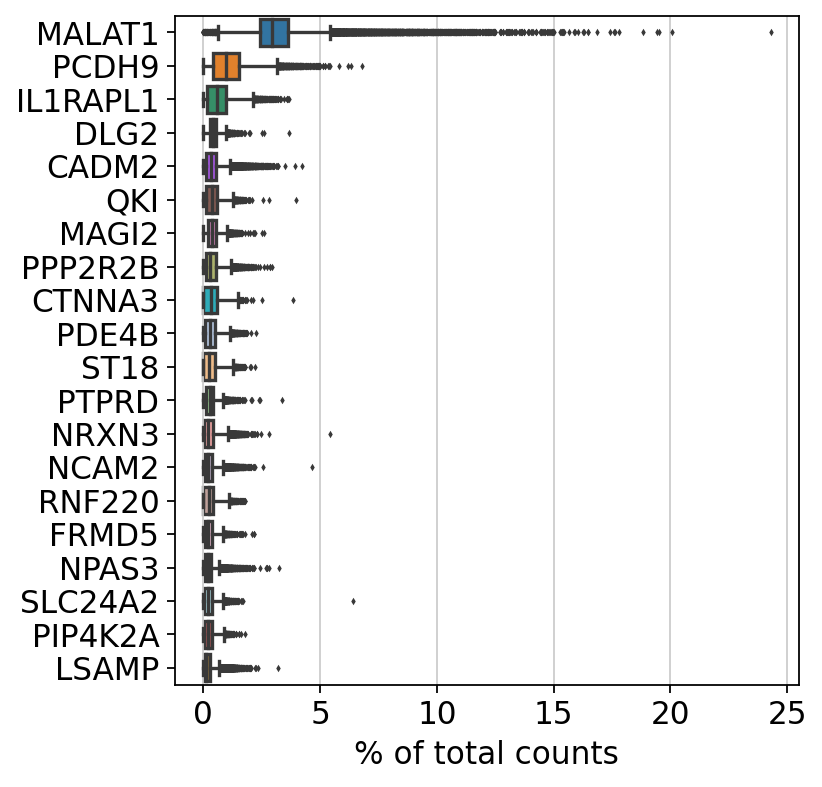

In [7]:
# Show those genes that yield the highest fraction of counts in each single cell, across all cells
sc.pl.highest_expr_genes(adata, n_top=20, )

In [8]:
# Only keep cells with at least 200 genes expressed and only keep genes which are expressed in at least 3 cells
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata

AnnData object with n_obs × n_vars = 61472 × 36066
    obs: 'rna_barcode', 'Sample.ID', 'Batch', 'Sex', 'Age', 'Diagnosis', 'UMAP_1', 'UMAP_2', 'cluster', 'celltype', 'n_genes'
    var: 'n_cells'
    layers: 'counts', 'lognorm'

In [9]:
# Predict and filter out doublets using Scrublet
sc.external.pp.scrublet(adata) #estimates doublets

/vsc-hard-mounts/leuven-data/343/vsc34319/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.42
Detected doublet rate = 0.8%
Estimated detectable doublet fraction = 49.9%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 1.5%


In [10]:
adata = adata[adata.obs['predicted_doublet'] == False] #do the actual filtering
adata

View of AnnData object with n_obs × n_vars = 61005 × 36066
    obs: 'rna_barcode', 'Sample.ID', 'Batch', 'Sex', 'Age', 'Diagnosis', 'UMAP_1', 'UMAP_2', 'cluster', 'celltype', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'n_cells'
    uns: 'scrublet'
    layers: 'counts', 'lognorm'

In [11]:
# check if mitochondrial genes are present
sum(adata.var_names.str.startswith('MT-'))

0

Comment:
    Mitochondrial genes are not present in our dataset

In [12]:
sc.pp.calculate_qc_metrics(adata, qc_vars=[], percent_top=None, log1p=False, inplace=True)
adata

/vsc-hard-mounts/leuven-data/343/vsc34319/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


AnnData object with n_obs × n_vars = 61005 × 36066
    obs: 'rna_barcode', 'Sample.ID', 'Batch', 'Sex', 'Age', 'Diagnosis', 'UMAP_1', 'UMAP_2', 'cluster', 'celltype', 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'scrublet'
    layers: 'counts', 'lognorm'

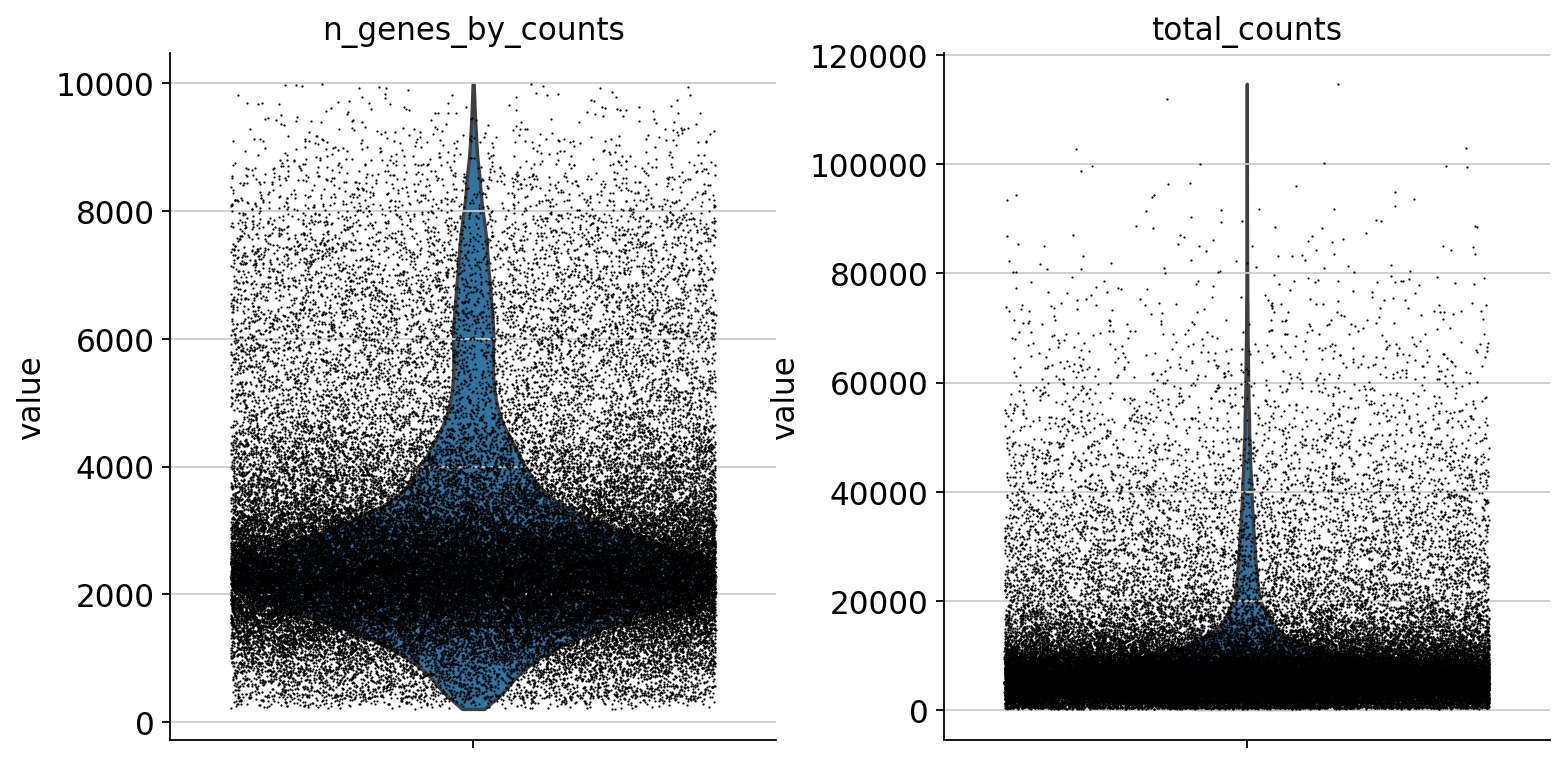

In [13]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, multi_panel=True)

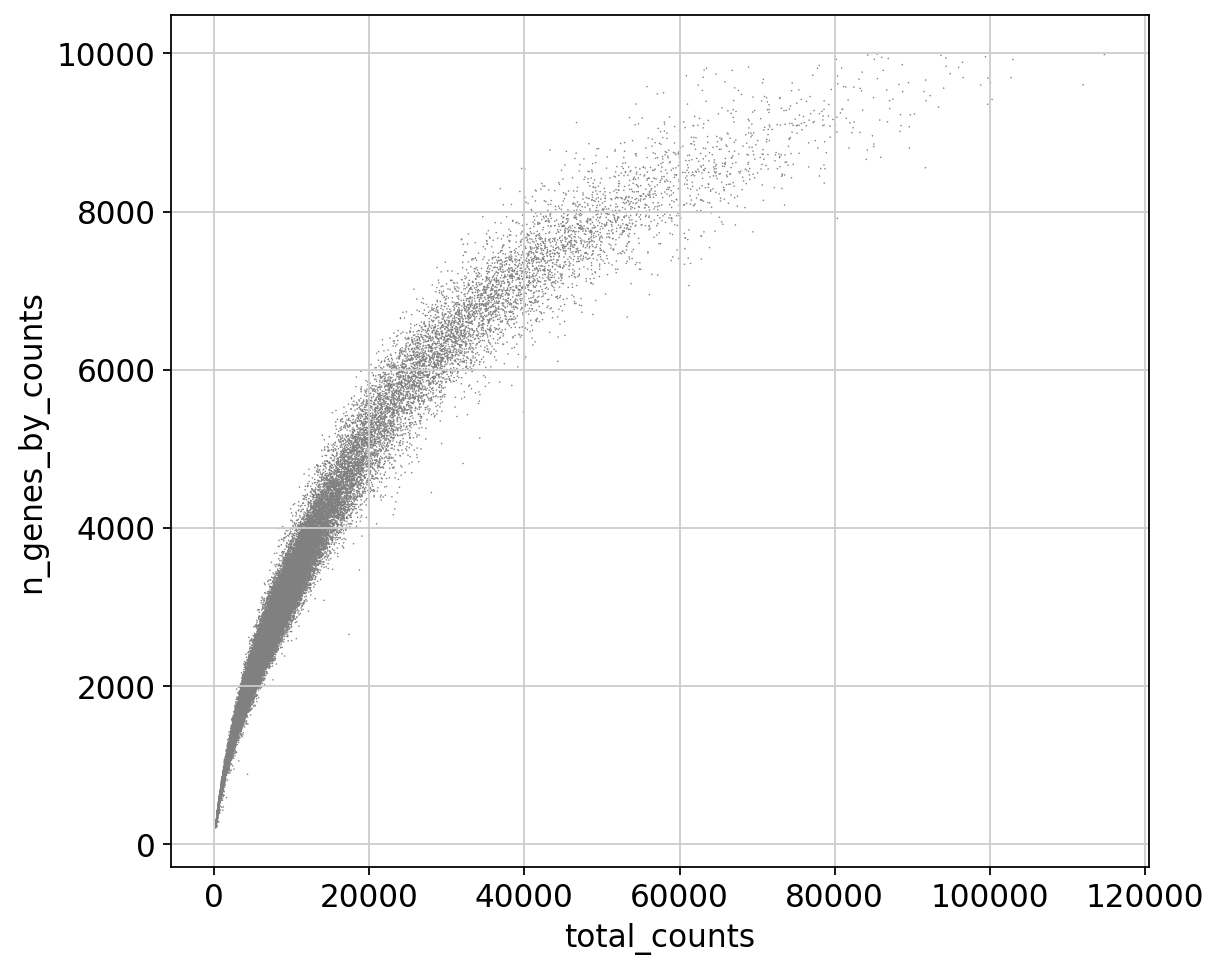

In [14]:
# Remove cells that have too many total counts
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [15]:
upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
lower_lim = np.quantile(adata.obs.n_genes_by_counts.values, .02)
print(f'{lower_lim} to {upper_lim}')


622.0 to 7696.8399999999965


In [16]:
adata = adata[(adata.obs.n_genes_by_counts < upper_lim) & (adata.obs.n_genes_by_counts > lower_lim)]

In [17]:
# Create a mask to filter out cells with more than 6500 genes, less than 200 genes or less than 0.2 mitochondrial umi counts
mask = np.logical_or((adata.obs.n_genes < 6500).values, (adata.obs.n_genes > 200).values)

# Data Normalization

In [18]:
# Total-count (library-size) correction normalize the data matrix X to 10,000 reads per cell, so that counts become comparable among cells
sc.pp.normalize_total(adata, target_sum=1e4)

# Logarithmize the data
sc.pp.log1p(adata)

adata.raw = adata

# Identify highly-variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

/vsc-hard-mounts/leuven-data/343/vsc34319/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


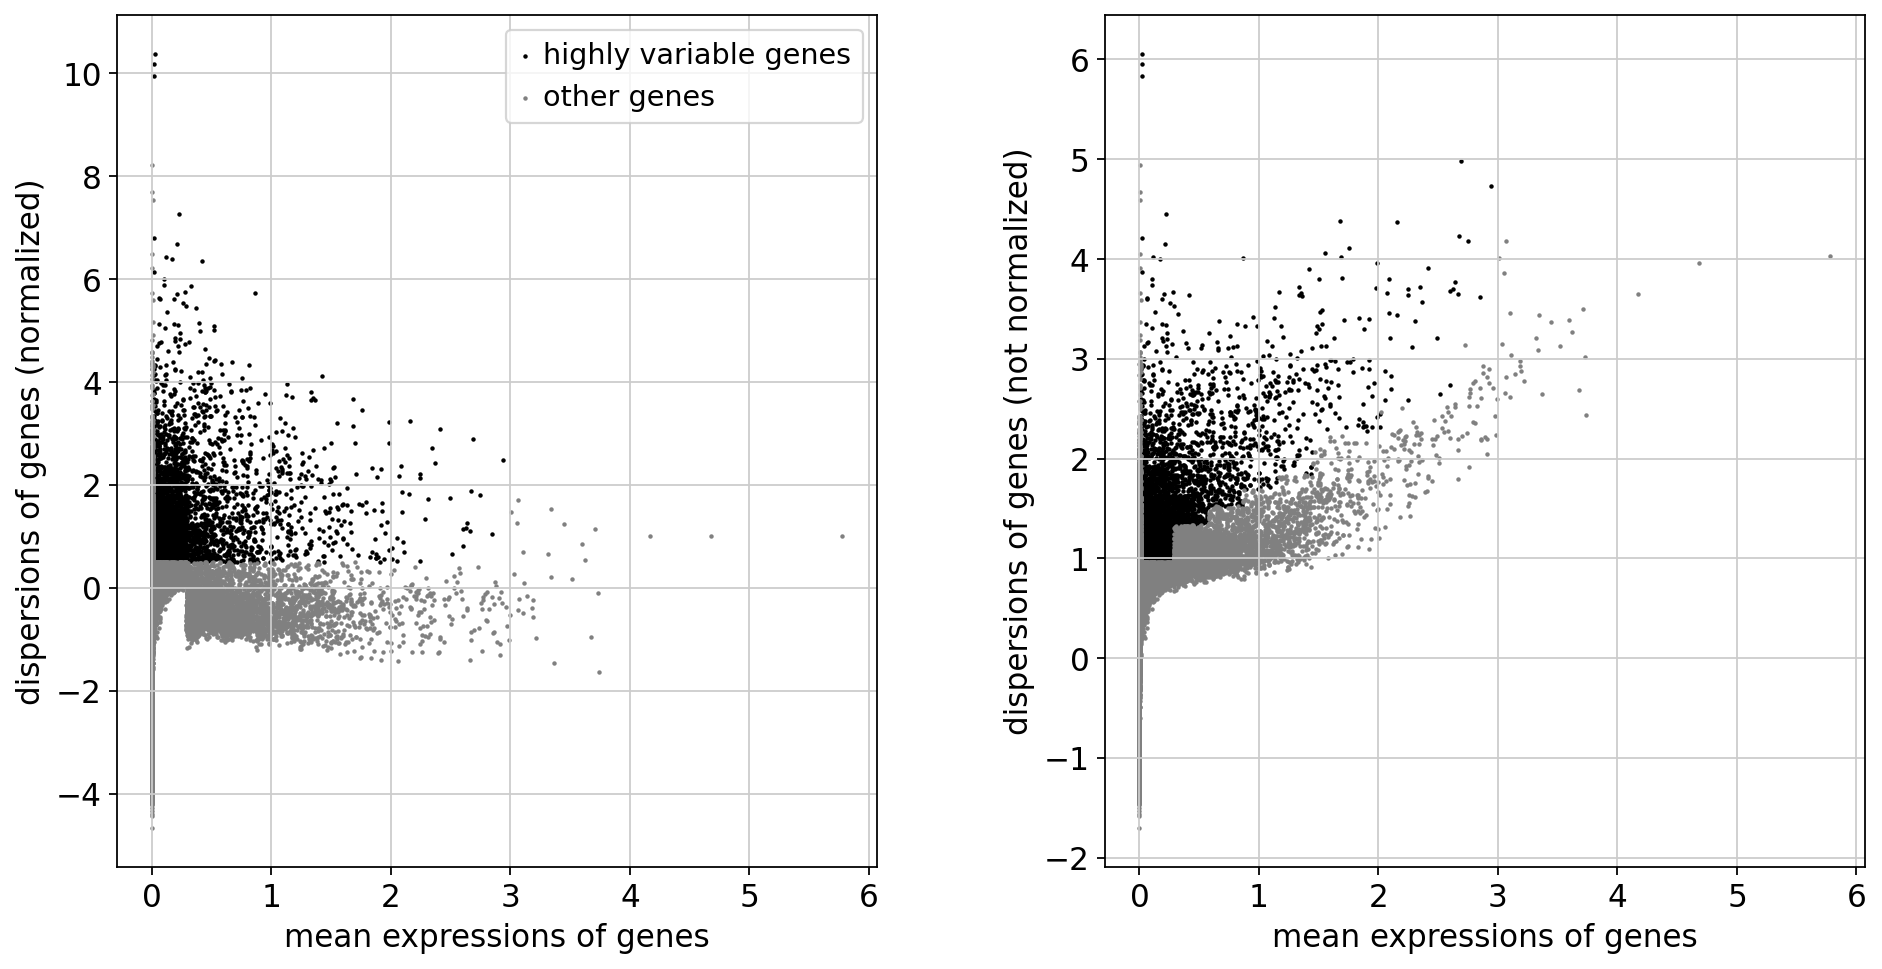

In [19]:
sc.pl.highly_variable_genes(adata)

In [20]:
# Do the filtering
adata = adata[:, adata.var.highly_variable]

# Regress out effects of total counts per cell and the percentage of batch genes expressed. Scale the data to unit variance.
sc.pp.regress_out(adata, ['total_counts', 'Batch'])

# Scale each gene to unit variance. Clip values exceeding standard deviation 10.
sc.pp.scale(adata, max_value=10)

adata

AnnData object with n_obs × n_vars = 58559 × 4668
    obs: 'rna_barcode', 'Sample.ID', 'Batch', 'Sex', 'Age', 'Diagnosis', 'UMAP_1', 'UMAP_2', 'cluster', 'celltype', 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'scrublet', 'log1p', 'hvg'
    layers: 'counts', 'lognorm'

/vsc-hard-mounts/leuven-data/343/vsc34319/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:182: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


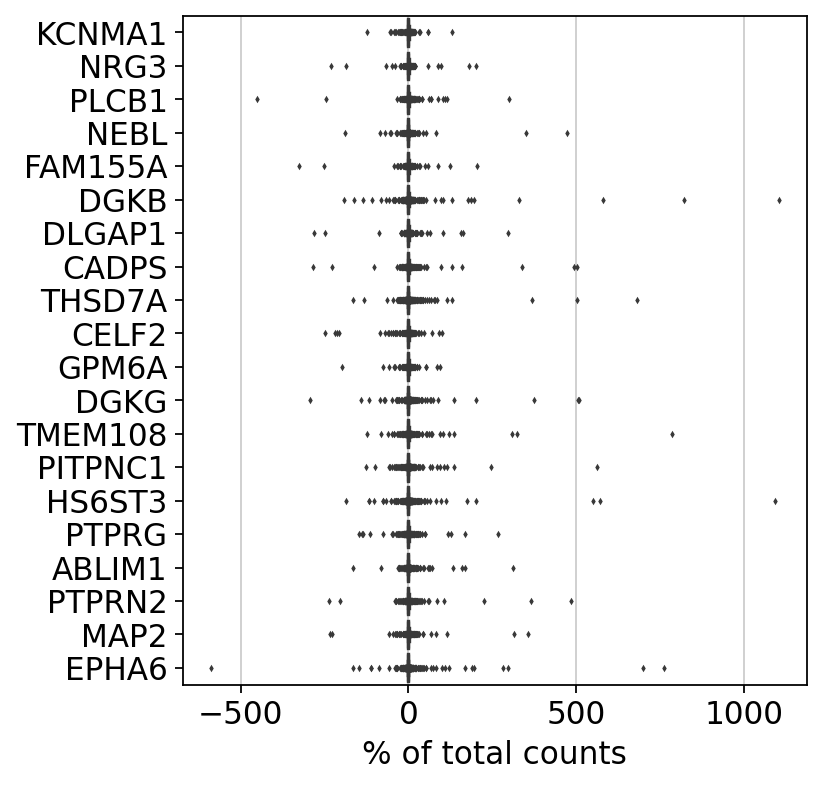

In [21]:
sc.pl.highest_expr_genes(adata, n_top=20)

# PCA

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [22]:
sc.tl.pca(adata, svd_solver='arpack')

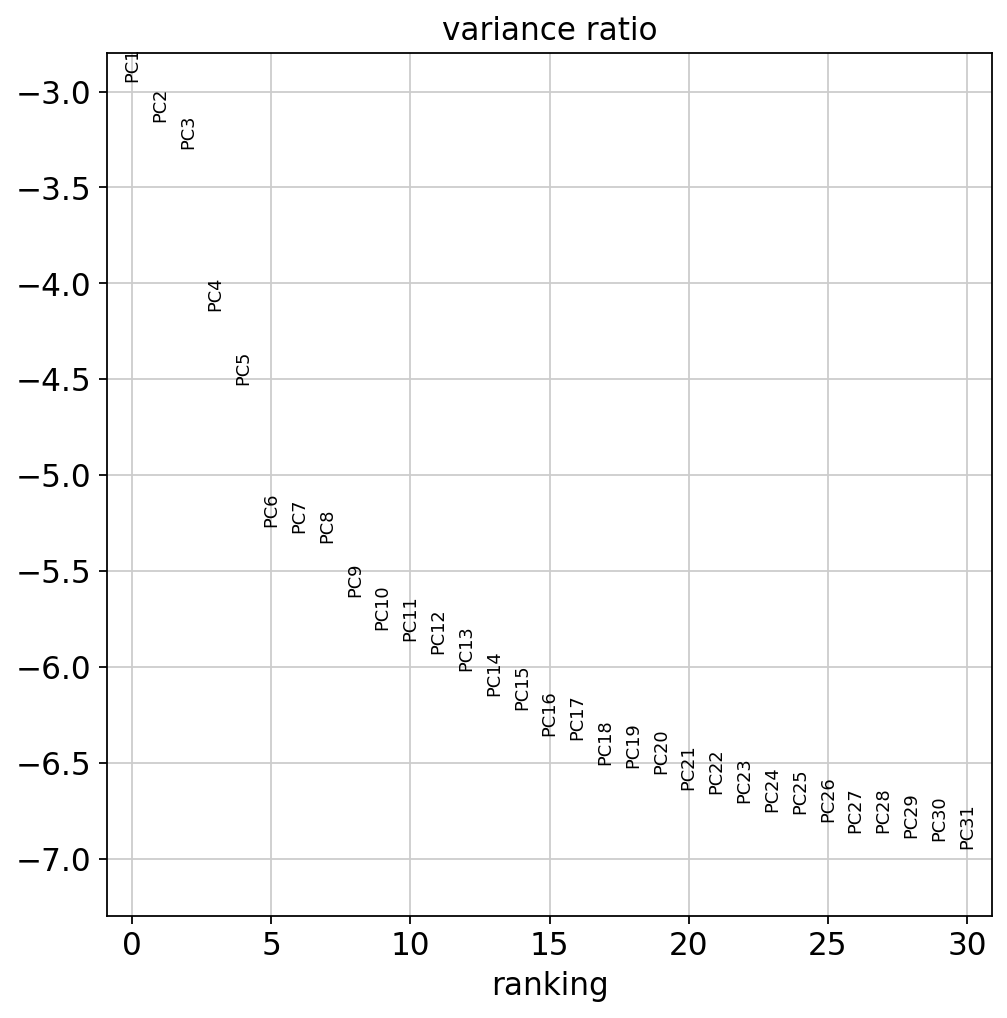

In [23]:
sc.pl.pca_variance_ratio(adata, log=True)

# Computing the neighborhood graph

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. For the sake of reproducing Seurat’s results, let’s take the following values.

In [24]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

# Embedding the neighborhood graph

We suggest embedding the graph in two dimensions using UMAP (McInnes et al., 2018), see below. It is potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preserves trajectories. In some ocassions, you might still observe disconnected clusters and similar connectivity violations.

In [27]:
sc.tl.umap(adata)

# Clustering the neighborhood graph

As with Seurat and many other frameworks, we recommend the Leiden graph-clustering method (community detection based on optimizing modularity) by Traag *et al.* (2018). Note that Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

/vsc-hard-mounts/leuven-data/343/vsc34319/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


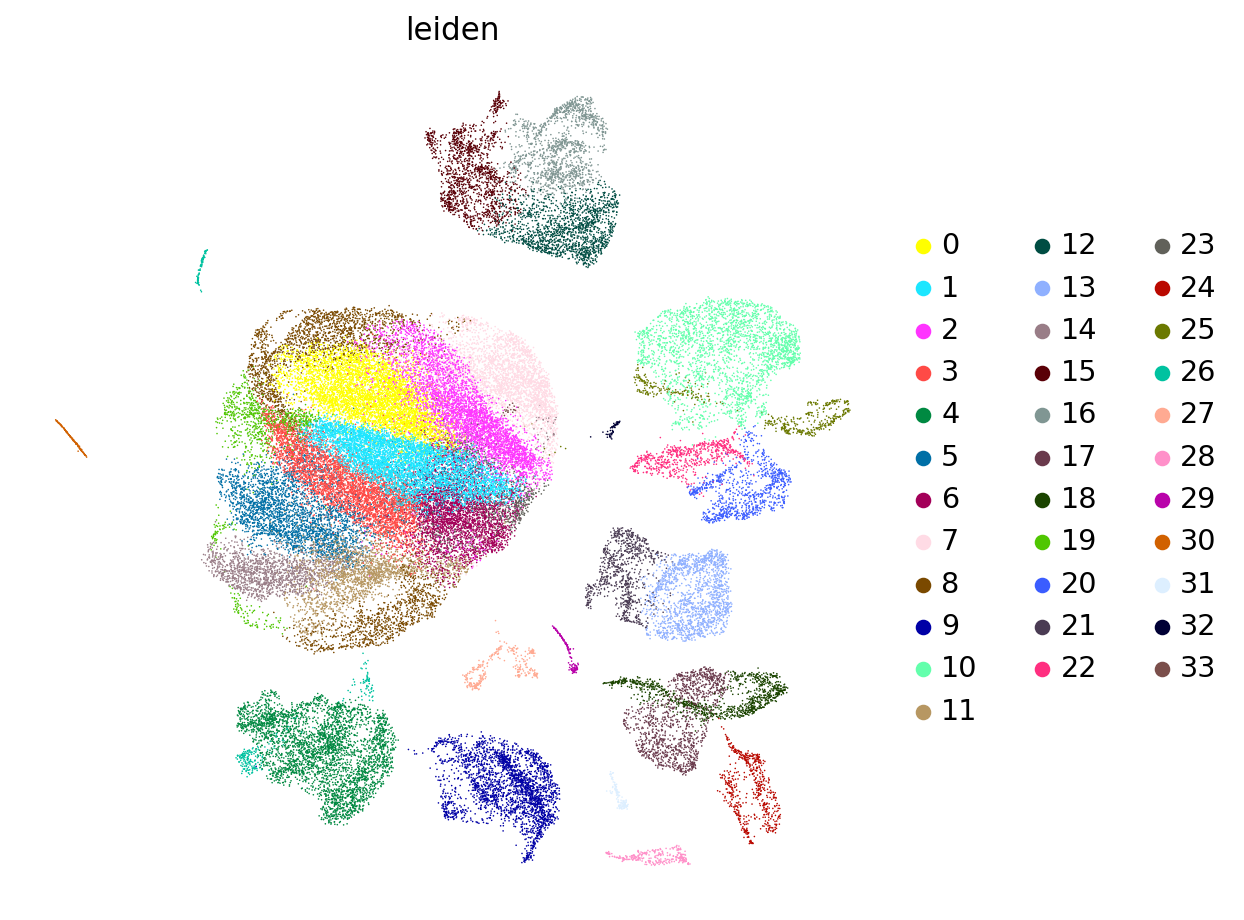

In [28]:
sc.tl.leiden(adata)
sc.pl.umap(adata, color=['leiden'])

/vsc-hard-mounts/leuven-data/343/vsc34319/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


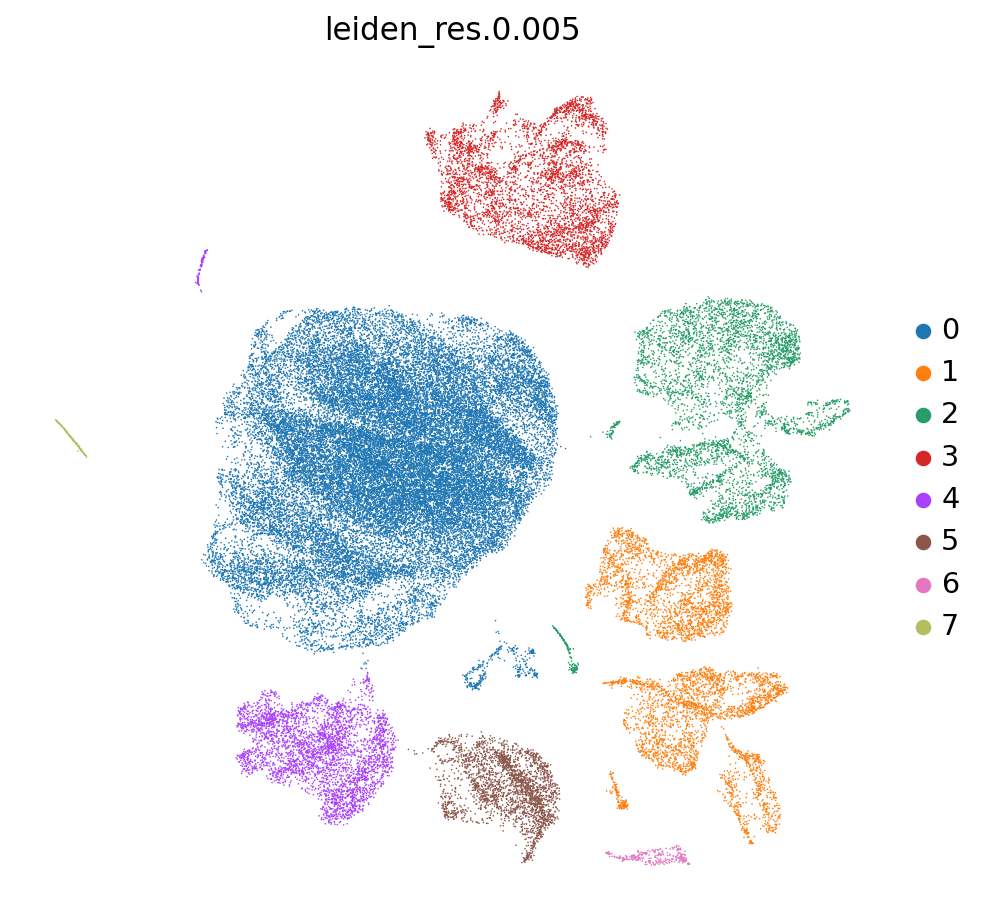

In [29]:
sc.tl.leiden(adata, resolution = 0.005, key_added = 'leiden_res.0.005')
sc.pl.umap(adata, color=['leiden_res.0.005'])

# Annotate clusters

/vsc-hard-mounts/leuven-data/343/vsc34319/miniconda3/envs/ibp-2022-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


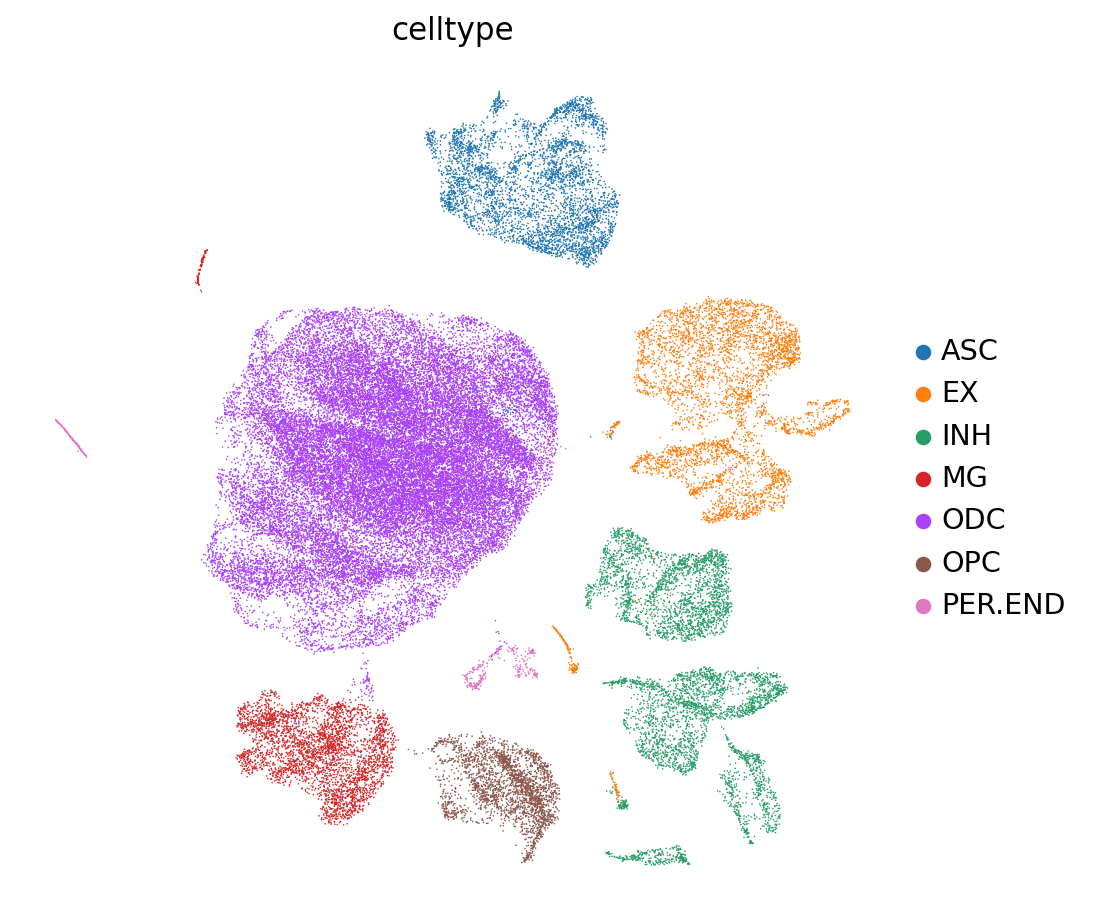

In [30]:
sc.pl.umap(adata, color='celltype')

# Finding marker genes

Let us compute a ranking for the highly differential genes in each cluster. For this, by default, the .raw attribute of AnnData is used in case it has been initialized before. The simplest and fastest method to do so is the t-test.

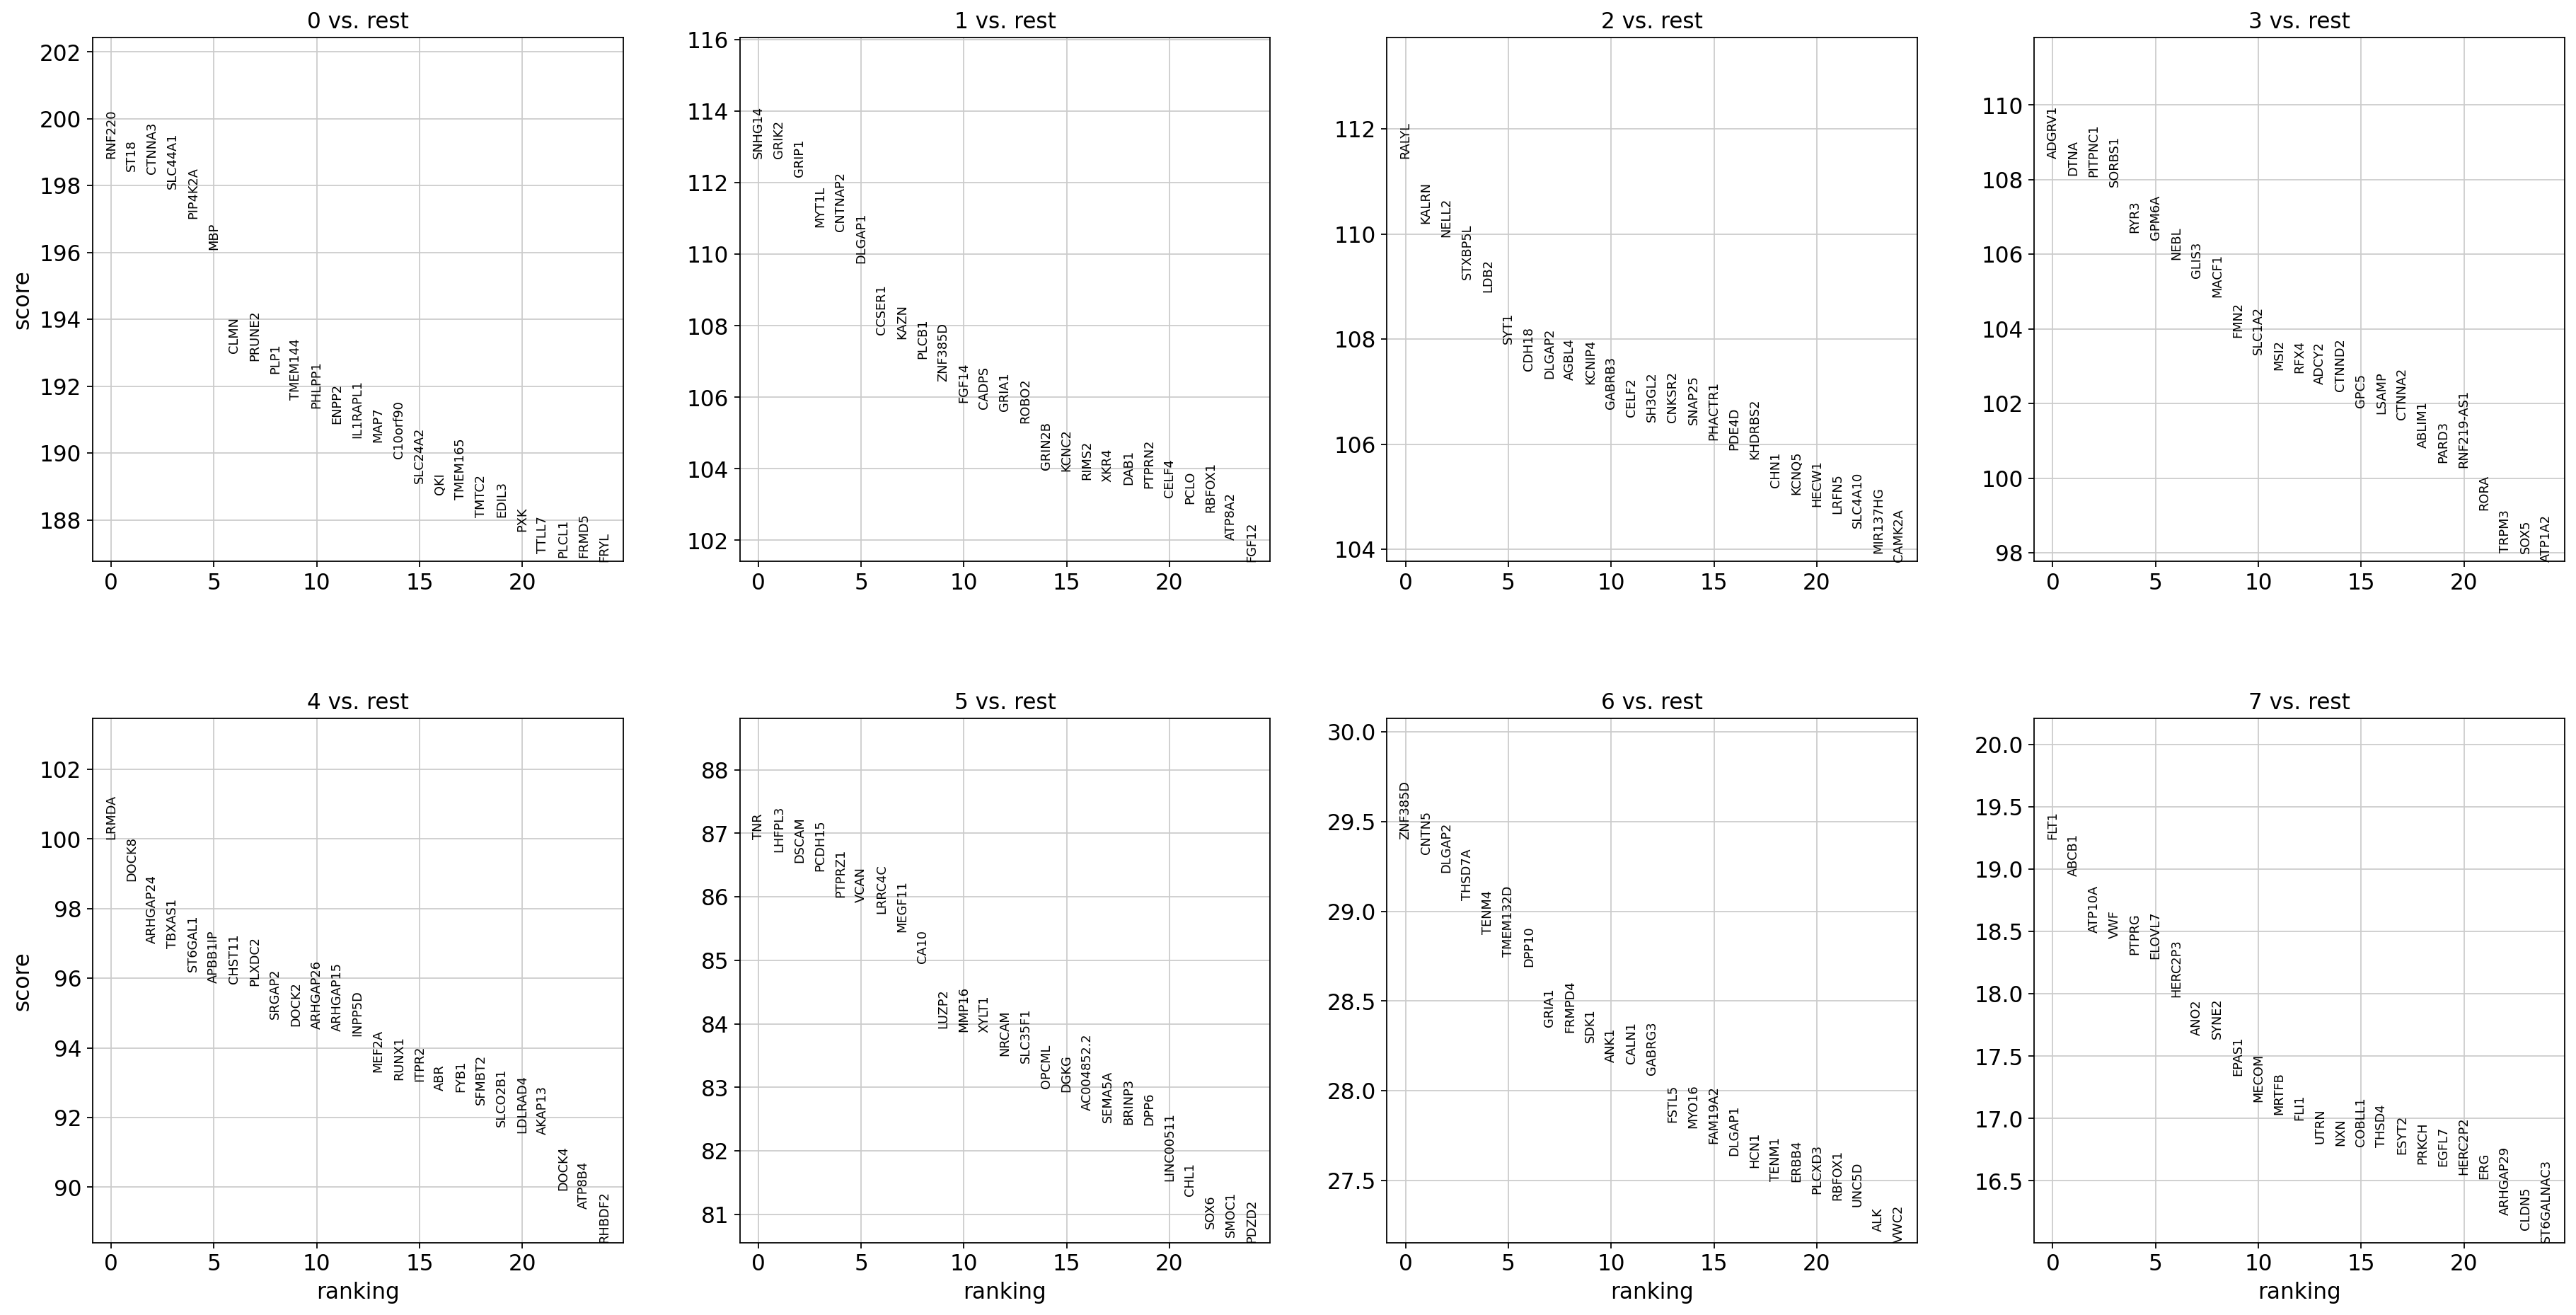

In [31]:
sc.tl.rank_genes_groups(adata, 'leiden_res.0.005', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [32]:
results = adata.uns['rank_genes_groups']

In [33]:
results

{'params': {'groupby': 'leiden_res.0.005',
  'reference': 'rest',
  'method': 'wilcoxon',
  'use_raw': True,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('RNF220', 'SNHG14', 'RALYL', 'ADGRV1', 'LRMDA', 'TNR', 'ZNF385D', 'FLT1'),
            ('ST18', 'GRIK2', 'KALRN', 'DTNA', 'DOCK8', 'LHFPL3', 'CNTN5', 'ABCB1'),
            ('CTNNA3', 'GRIP1', 'NELL2', 'PITPNC1', 'ARHGAP24', 'DSCAM', 'DLGAP2', 'ATP10A'),
            ...,
            ('NAV3', 'PTPRK', 'TCF12', 'ELMO1', 'NCAM1', 'SHTN1', 'DOCK4', 'PPP2R2B'),
            ('KCNMA1', 'PIP4K2A', 'ZBTB20', 'ANK3', 'DLG2', 'LIMCH1', 'PDE4B', 'NCAM1'),
            ('CELF2', 'ARAP2', 'QKI', 'IL1RAPL1', 'MAGI2', 'MAP7', 'FMNL2', 'ANK2')],
           dtype=[('0', 'O'), ('1', 'O'), ('2', 'O'), ('3', 'O'), ('4', 'O'), ('5', 'O'), ('6', 'O'), ('7', 'O')]),
 'scores': rec.array([( 198.81186,  112.67935 ,  111.43473 ,  108.5661 ,   99.98404,  86.90204 ,  29.399572,  19.238485),
            ( 198.42827,  112.676956,  11

In [34]:
results['names']['0']

array(['RNF220', 'ST18', 'CTNNA3', ..., 'NAV3', 'KCNMA1', 'CELF2'],
      dtype=object)

In [35]:
results['names'].dtype.names

('0', '1', '2', '3', '4', '5', '6', '7')

In [36]:
out = np.array([[0,0,0,0,0]])
for group in results['names'].dtype.names:
    out = np.vstack((out, np.vstack((results['names'][group],
                                     results['scores'][group],
                                     results['pvals_adj'][group],
                                     results['logfoldchanges'][group],
                                     np.array([group] * len(results['names'][group])).astype('object'))).T))

In [37]:
out.shape

(288529, 5)

In [38]:
markers = pd.DataFrame(out[1:], columns = ['Gene', 'scores', 'pval_adj', 'lfc', 'cluster'])


In [39]:
markers


Gene      scores pval_adj       lfc cluster
0        RNF220  198.811859      0.0  6.529946       0
1          ST18  198.428268      0.0  7.491802       0
2        CTNNA3  198.353683      0.0  6.317069       0
3       SLC44A1  197.896698      0.0  4.458519       0
4       PIP4K2A  197.022018      0.0  4.645001       0
...         ...         ...      ...       ...     ...
288523    PCDH9  -17.482721      0.0 -5.211185       7
288524      DST  -17.618275      0.0 -4.337204       7
288525  PPP2R2B  -17.846092      0.0 -6.193726       7
288526    NCAM1  -17.894588      0.0 -5.822223       7
288527     ANK2   -18.06745      0.0 -5.571552       7

[288528 rows x 5 columns]

In [40]:
#save marker file
markers.to_pickle("markers_AD.pkl")

In [41]:
markers_MG = markers[markers.cluster == '4']

In [42]:
markers_MG.head(30)

Gene     scores pval_adj       lfc cluster
144264     LRMDA  99.984039      0.0  7.422375       4
144265     DOCK8  98.800438      0.0  9.833159       4
144266  ARHGAP24  96.993507      0.0   6.60739       4
144267    TBXAS1  96.865181      0.0  7.980005       4
144268   ST6GAL1  96.181366      0.0  6.877398       4
144269   APBB1IP  95.858765      0.0  9.711458       4
144270    CHST11  95.843971      0.0   5.61532       4
144271    PLXDC2  95.776054      0.0  3.897597       4
144272    SRGAP2  94.833809      0.0  4.782835       4
144273     DOCK2  94.634628      0.0  7.463315       4
144274  ARHGAP26  94.547829      0.0  4.702866       4
144275  ARHGAP15  94.488304      0.0  8.297124       4
144276    INPP5D  94.340492      0.0  8.984899       4
144277     MEF2A  93.305611      0.0  3.496401       4
144278     RUNX1  93.084312      0.0  6.763228       4
144279     ITPR2  93.036324      0.0  4.508607       4
144280       ABR  92.776703      0.0  4.829771       4
144281      FYB1   92.73275      0.0  9.294722       4
144282    SFMBT2  92.371536      0.0  4.286187       4
144283   SLCO2B1  91.728386      0.0  9.093182       4
144284   LDLRAD4  91.547684      0.0  3.647281       4
144285    AKAP13  91.523071      0.0  5.272558       4
144286     DOCK4  89.900208      0.0  2.557904       4
144287    ATP8B4  89.388451      0.0   7.07525       4
144288    RHBDF2  88.409904      0.0  9.040595       4
144289     MEF2C  88.056252      0.0  4.493492       4
144290     BMP2K  87.668121      0.0  4.420812       4
144291     ZFHX3  87.430489      0.0  4.513089       4
144292     PTPRC  87.335648      0.0   9.42809       4
144293    FRMD4A  87.238518      0.0  4.067104       4

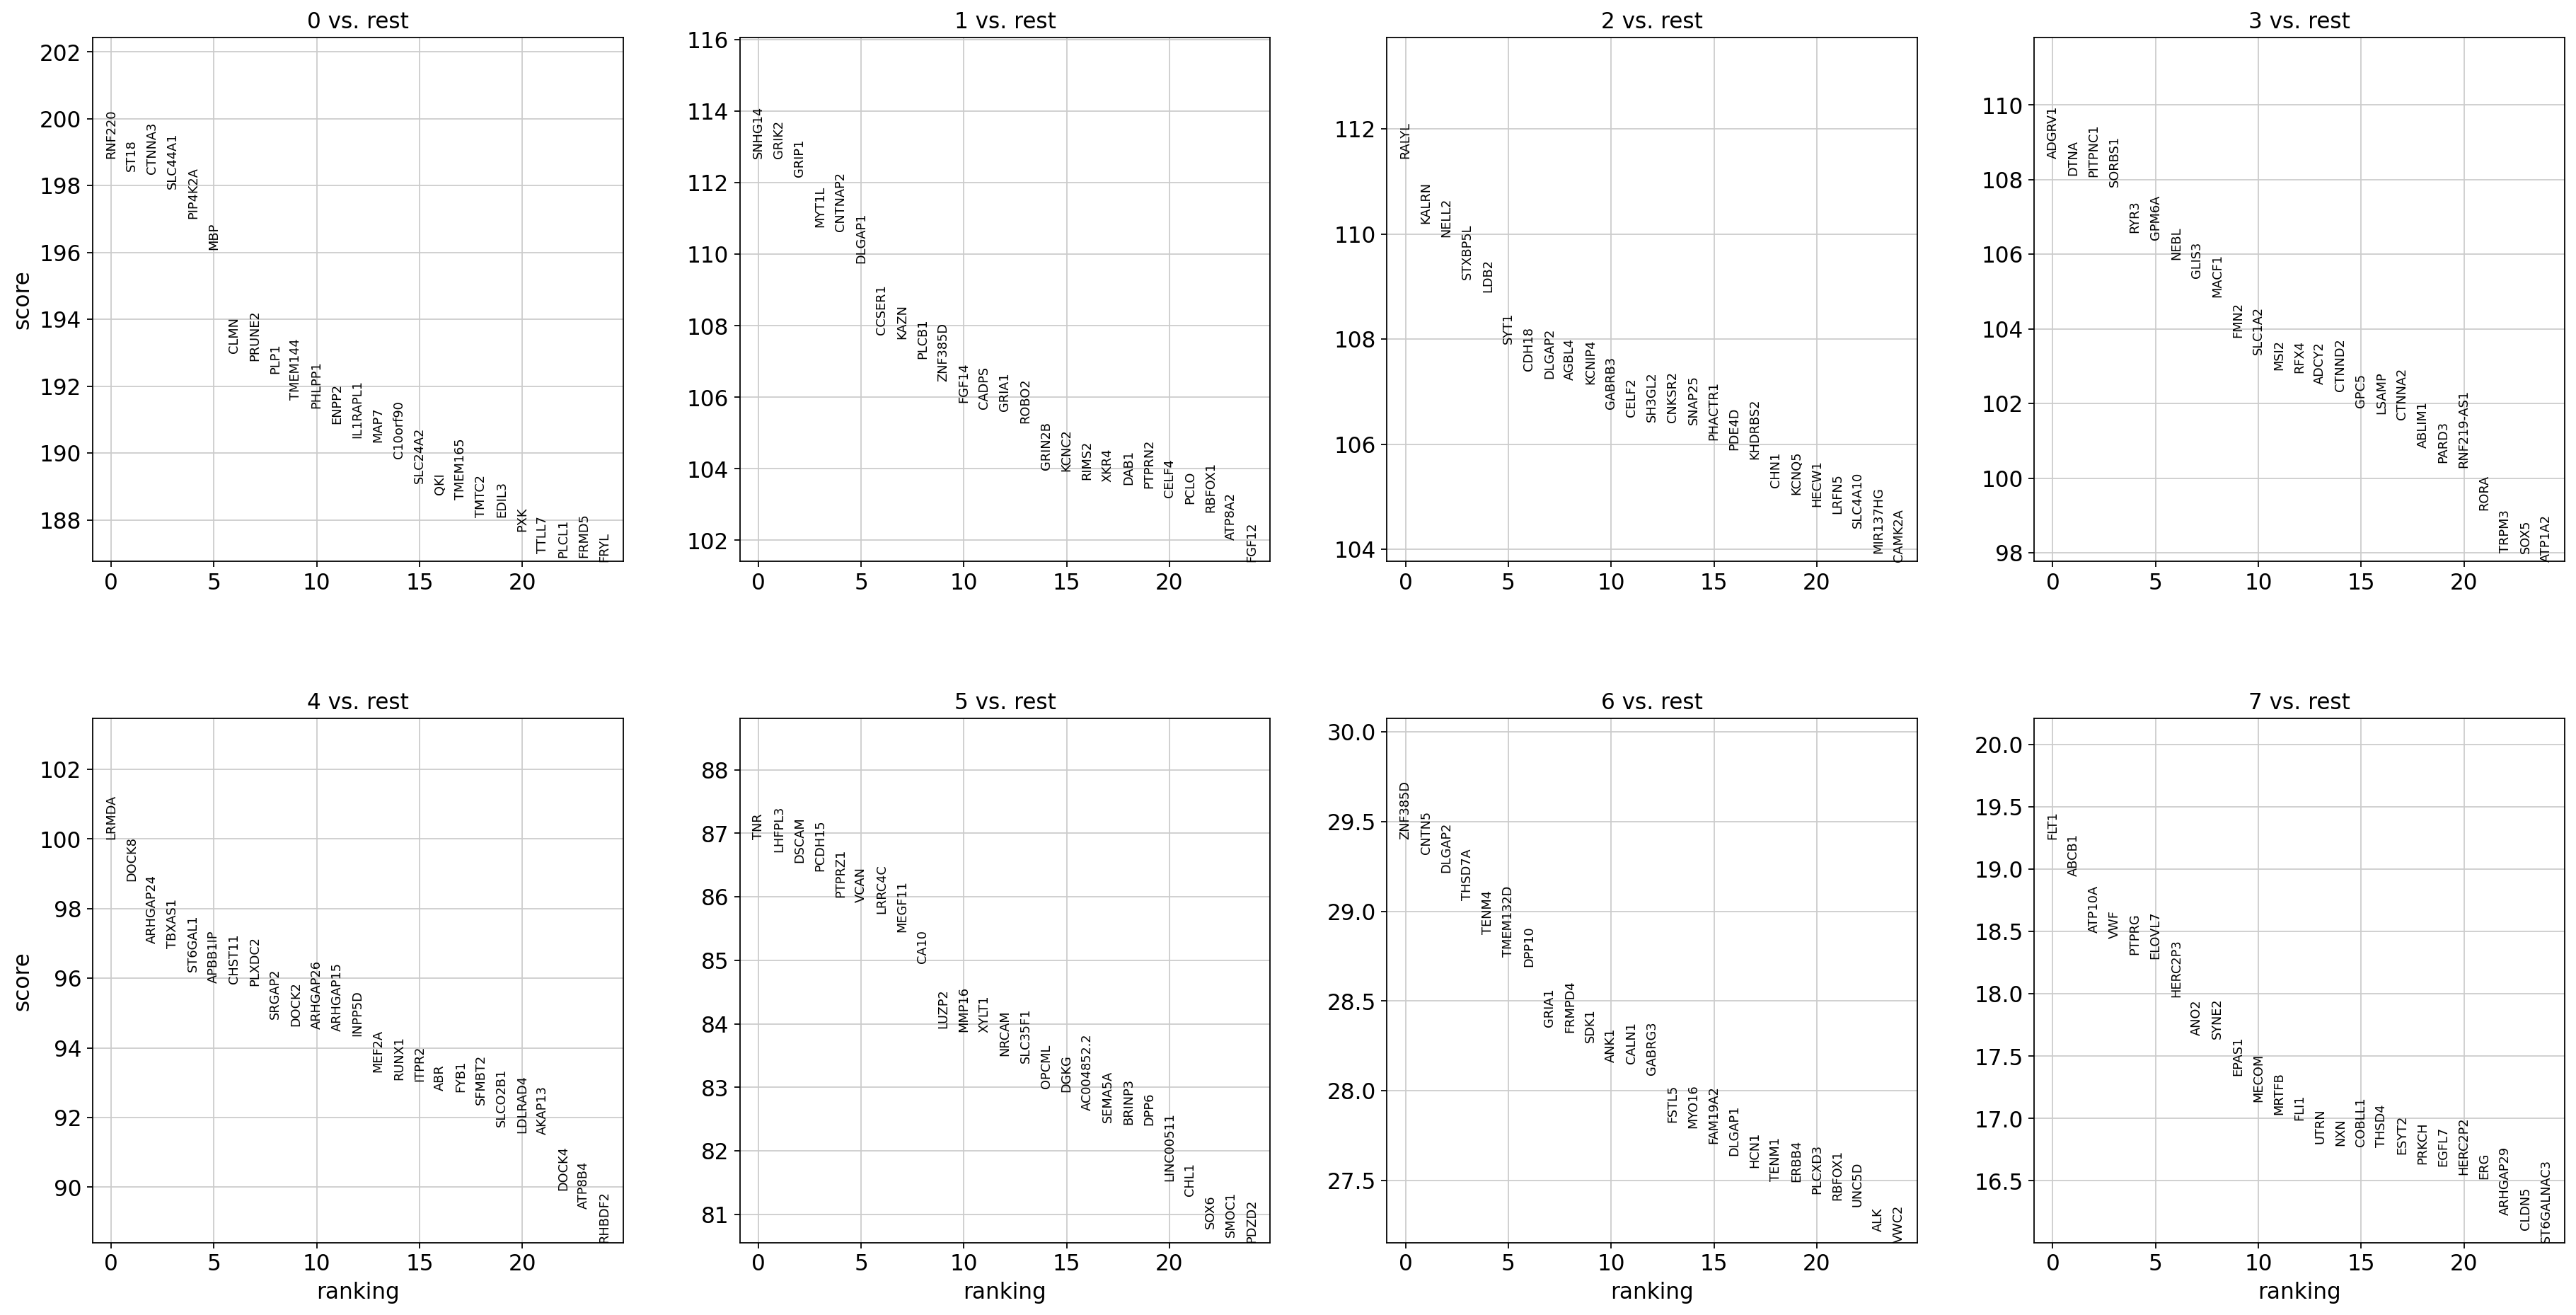

In [43]:
sc.tl.rank_genes_groups(adata, 'leiden_res.0.005', method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key="wilcoxon")

In [44]:
genes = sc.get.rank_genes_groups_df(adata, group='4', key='wilcoxon')['names'][:5]

# GSEA & Functional analysis Microglia

In [45]:
#Available databases : ‘Human’, ‘Mouse’, ‘Yeast’, ‘Fly’, ‘Fish’, ‘Worm’ 
gene_set_names = gseapy.get_library_name(organism='Human')
print(gene_set_names)

['ARCHS4_Cell-lines', 'ARCHS4_IDG_Coexp', 'ARCHS4_Kinases_Coexp', 'ARCHS4_TFs_Coexp', 'ARCHS4_Tissues', 'Achilles_fitness_decrease', 'Achilles_fitness_increase', 'Aging_Perturbations_from_GEO_down', 'Aging_Perturbations_from_GEO_up', 'Allen_Brain_Atlas_10x_scRNA_2021', 'Allen_Brain_Atlas_down', 'Allen_Brain_Atlas_up', 'Azimuth_Cell_Types_2021', 'BioCarta_2013', 'BioCarta_2015', 'BioCarta_2016', 'BioPlanet_2019', 'BioPlex_2017', 'CCLE_Proteomics_2020', 'CORUM', 'COVID-19_Related_Gene_Sets', 'COVID-19_Related_Gene_Sets_2021', 'Cancer_Cell_Line_Encyclopedia', 'CellMarker_Augmented_2021', 'ChEA_2013', 'ChEA_2015', 'ChEA_2016', 'ChEA_2022', 'Chromosome_Location', 'Chromosome_Location_hg19', 'ClinVar_2019', 'DSigDB', 'Data_Acquisition_Method_Most_Popular_Genes', 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019', 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019', 'Descartes_Cell_Types_and_Tissue_2021', 'Diabetes_Perturbations_GEO_2022', 'DisGeNET', 'Disease_Perturbations_from_GEO_down', 'Disease

In [46]:
# get significant DEGs
glist = sc.get.rank_genes_groups_df(adata, group='4', 
                                    key='wilcoxon', log2fc_min=0.25
                                   )['names'].squeeze().str.strip().tolist()
print(len(glist))

9694


In [48]:
enr_res = gseapy.enrichr(gene_list=glist,
                     organism='Human',
                     gene_sets='GO_Biological_Process_2021')

In [49]:
enr_res.results.head()

Gene_set  \
0  GO_Biological_Process_2021   
1  GO_Biological_Process_2021   
2  GO_Biological_Process_2021   
3  GO_Biological_Process_2021   
4  GO_Biological_Process_2021   

                                                Term Overlap       P-value  \
0  SRP-dependent cotranslational protein targetin...   70/90  1.076059e-08   
1  nuclear-transcribed mRNA catabolic process, no...  83/113  5.286722e-08   
2  cotranslational protein targeting to membrane ...   71/94  7.294541e-08   
3               cytoplasmic translation (GO:0002181)   70/93  1.146152e-07   
4  positive regulation of T cell activation (GO:0...   58/75  2.803301e-07   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0          0.000063            0                     0    3.740752   
1          0.000141            0                     0    2.958097   
2          0.000141            0                     0    3.298678   
3          0.000167            0                     0    3.251879   
4          0.000326            0                     0    3.642969   

   Combined Score                                              Genes  
0       68.632987  RPL4;RPL5;RPL3;RPL32;RPL31;RPL34;RPLP1;RPLP0;R...  
1       49.564336  RPL4;RPL5;SMG1;RPL3;RPL32;RPL31;RPL34;RPLP1;EI...  
2       54.208997  RPL4;RPL5;TRAM1;RPL3;RPL32;RPL31;RPL34;RPLP1;R...  
3       51.970512  RPL4;RPL5;RPL3;RPL32;RPL31;RPL34;RPLP1;RPLP0;R...  
4       54.962555  CD86;IL21;TFRC;CD81;CD80;IL23R;DOCK8;SIRPG;TNF...

<AxesSubplot: title={'center': 'GO_Biological_Process_2021'}, xlabel='-log$_{10}$(Adjusted P-value)'>

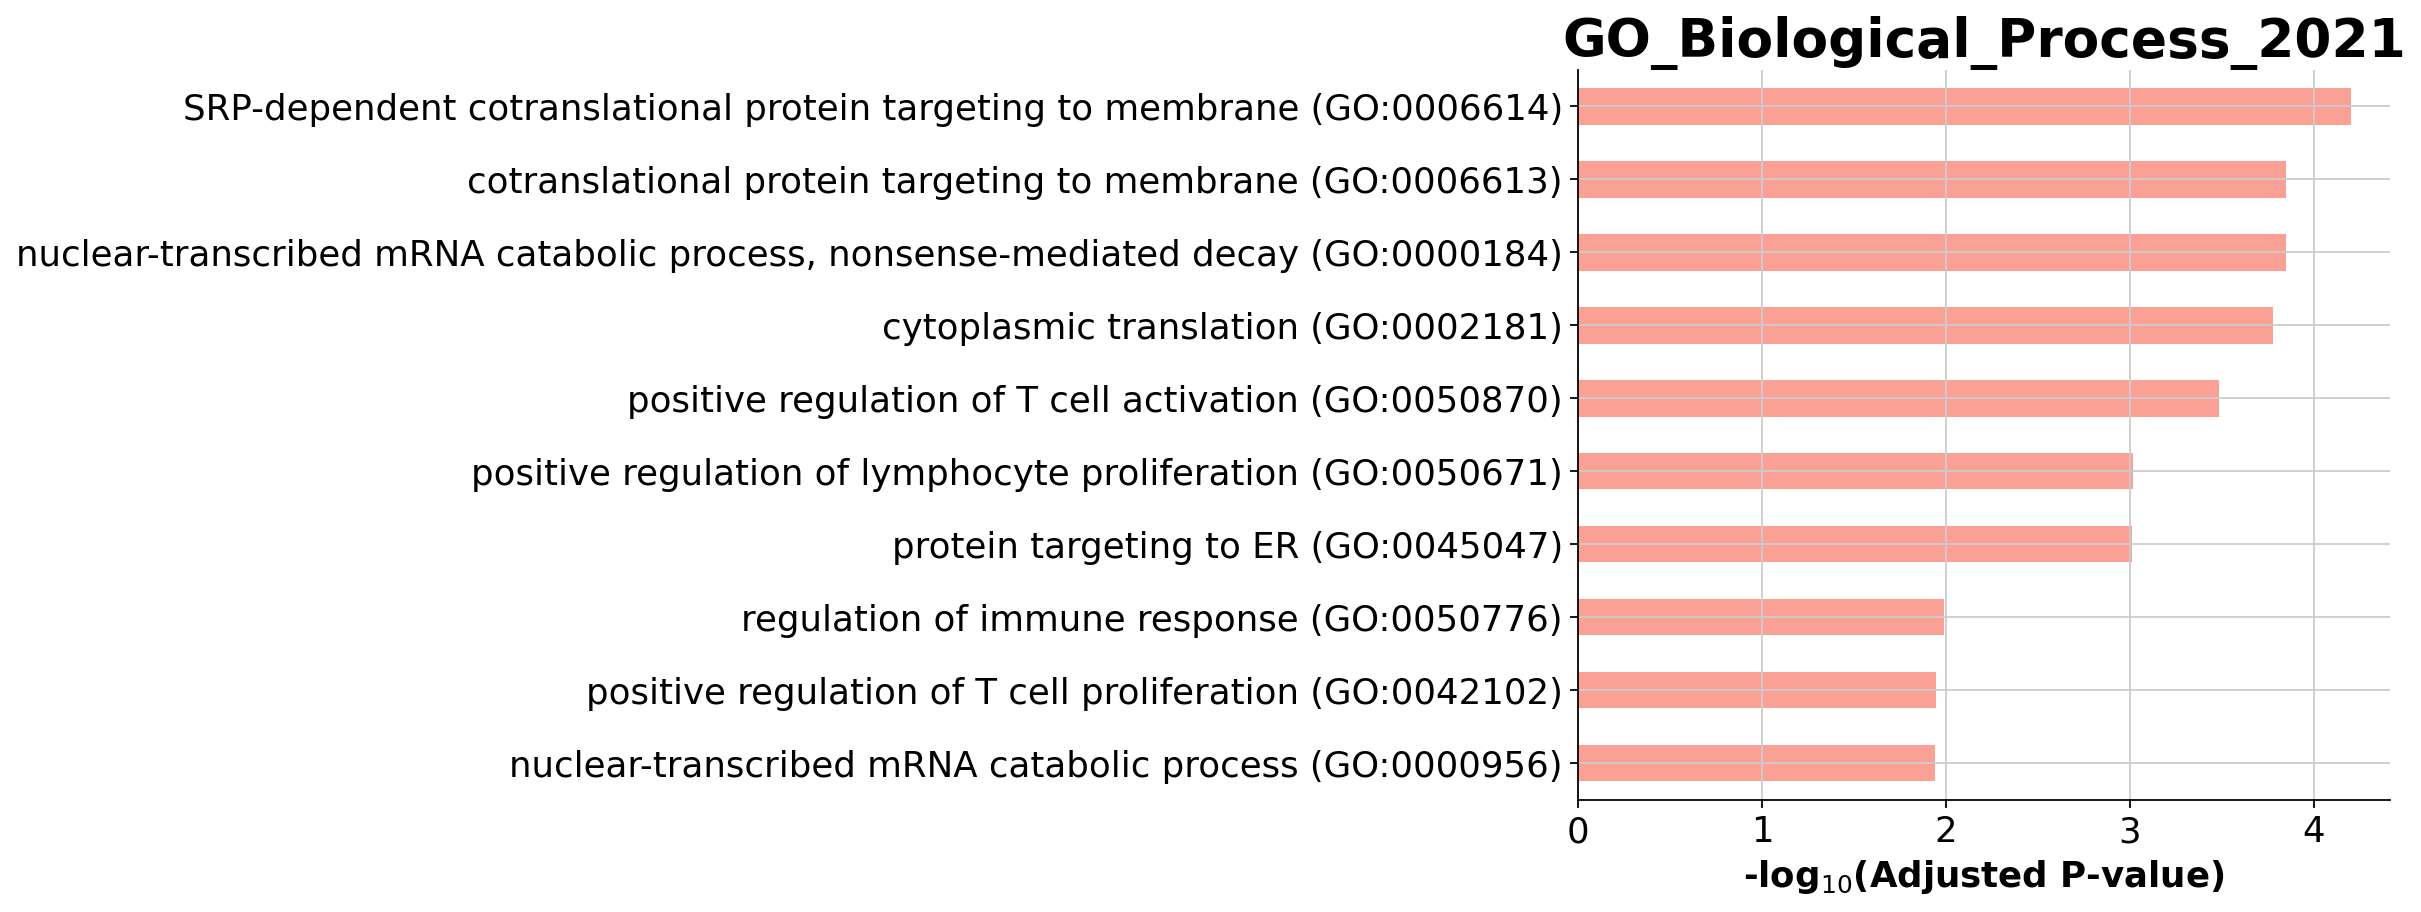

In [50]:
gseapy.barplot(enr_res.res2d,title='GO_Biological_Process_2021')

In [61]:
enr_res2 = gseapy.enrichr(gene_list=glist,
                     organism='Human',
                     gene_sets='WikiPathway_2021_Human')

In [62]:
enr_res2.results.head()

Gene_set                                               Term  \
0  WikiPathway_2021_Human          TYROBP causal network in microglia WP3945   
1  WikiPathway_2021_Human               Cytoplasmic Ribosomal Proteins WP477   
2  WikiPathway_2021_Human       T-cell receptor (TCR) signaling pathway WP69   
3  WikiPathway_2021_Human     Microglia Pathogen Phagocytosis Pathway WP3937   
4  WikiPathway_2021_Human  Nucleotide-binding Oligomerization Domain (NOD...   

  Overlap       P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0   57/61  4.304032e-14      2.625459e-11            0                     0   
1   71/89  1.115388e-09      3.401933e-07            0                     0   
2   65/90  3.863915e-06      7.856628e-04            0                     0   
3   31/40  1.644245e-04      2.507473e-02            0                     0   
4   31/41  3.610050e-04      3.730510e-02            0                     0   

   Odds Ratio  Combined Score  \
0   15.233319      468.830376   
1    4.217026       86.930049   
2    2.776052       34.600233   
3    3.670438       31.980745   
4    3.303074       26.182205   

                                               Genes  
0  CD84;ITGAM;FKBP15;NCF2;ITGB2;PLEK;GIMAP2;LOXL3...  
1  RPL4;RPL5;RPL3;RPL32;RPL31;RPL34;RPLP1;RPLP0;R...  
2  ITK;CD83;CD3G;CD3E;CD3D;IKBKB;PSTPIP1;GRAP2;AK...  
3  C1QB;C1QA;ITGAM;NCF1;NCF2;ARPC1B;ITGB2;NCF4;PI...  
4  NOD1;PRDM1;NOD2;NLRC4;MEFV;PYCARD;IKBKB;CASP7;...

<AxesSubplot: title={'center': 'WikiPathway_2021_Human'}, xlabel='-log$_{10}$(Adjusted P-value)'>

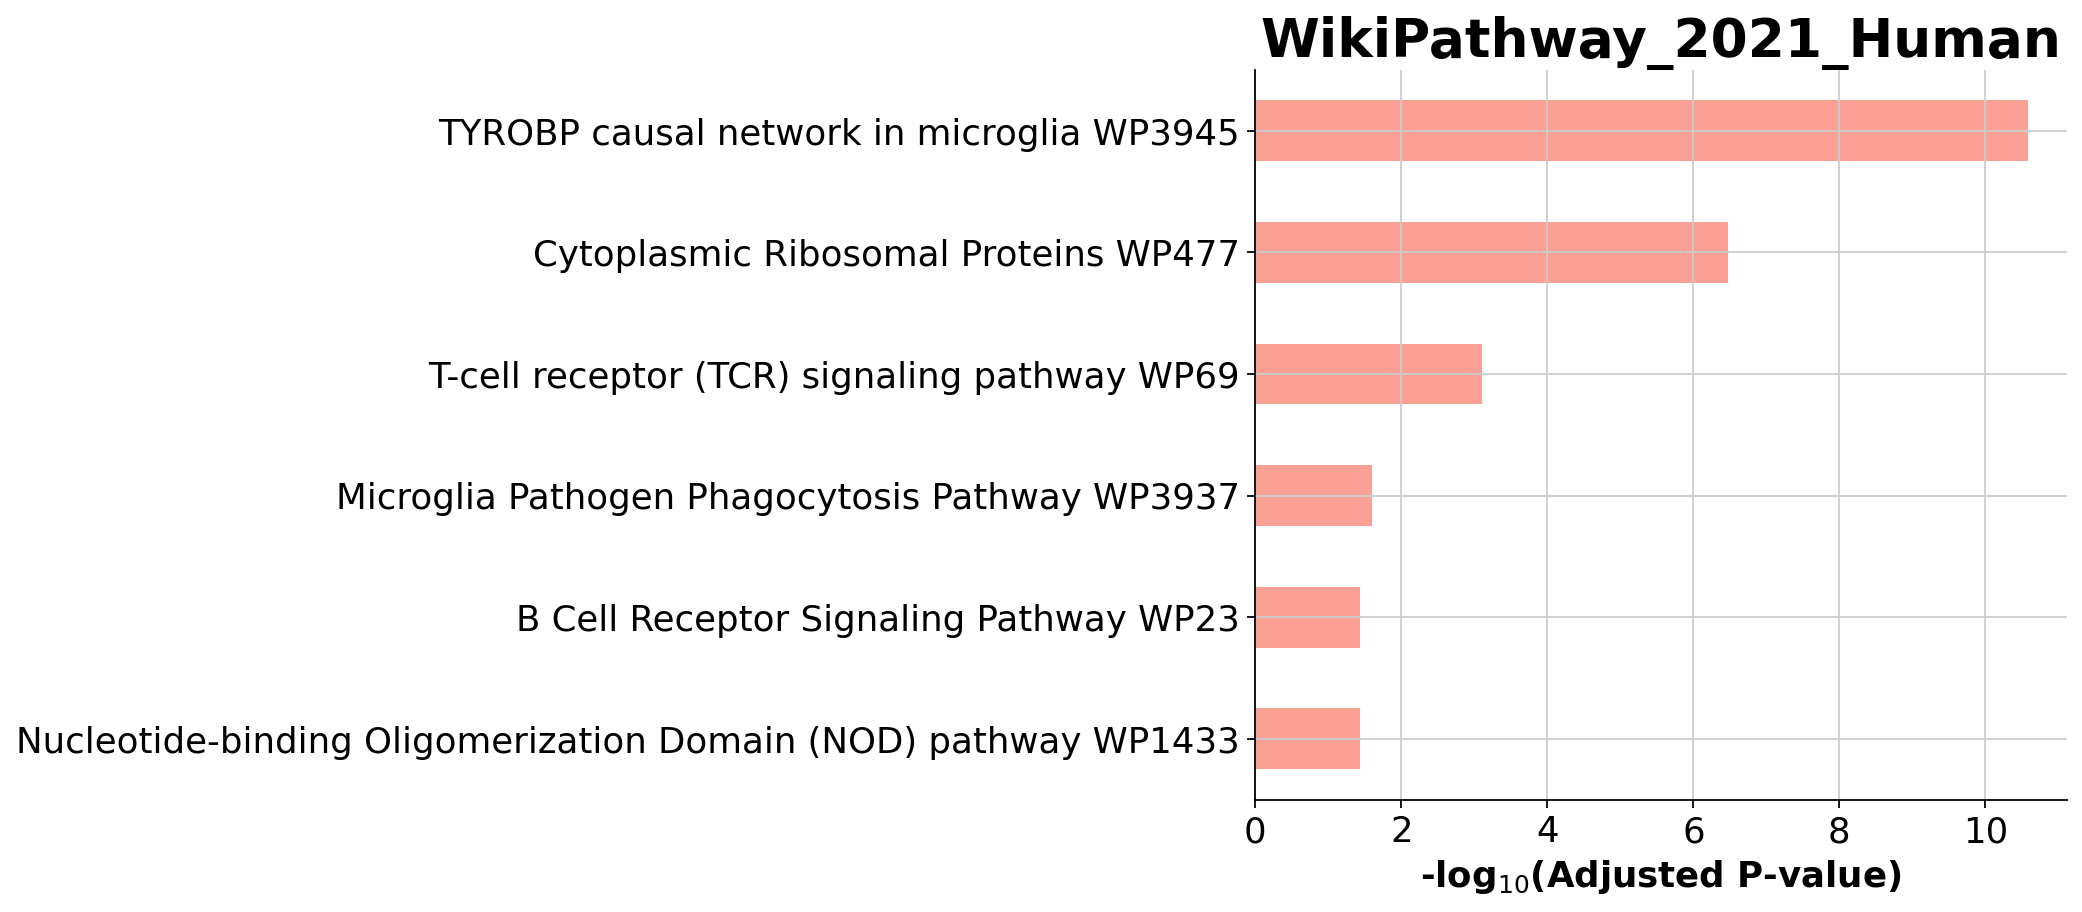

In [63]:
gseapy.barplot(enr_res2.res2d,title='WikiPathway_2021_Human')

In [55]:
markers_MG[markers_MG.Gene == "TYROBP"]

Gene     scores pval_adj       lfc cluster
145013  TYROBP  23.500378      0.0  8.226981       4

In [25]:
adata.obs.groupby('celltype')['Diagnosis'].value_counts()

celltype  Diagnosis
ASC       AD            2816
          Control       1631
EX        AD            3719
          Control       1198
INH       AD            3920
          Control       1665
MG        AD            2517
          Control       1267
ODC       AD           21879
          Control      14890
OPC       AD            1657
          Control        986
PER.END   AD             269
          Control        145
Name: Diagnosis, dtype: int64

In [26]:
adata.obs['Diagnosis'] = pd.Categorical(adata.obs['Diagnosis'], categories=["AD", "Control"], ordered=True)
indices = adata.obs.sort_values(['celltype', 'Diagnosis']).index
adata = adata[indices,:]

In [27]:
MGdata = adata[adata.obs.celltype == "MG"].copy()
MGdata

AnnData object with n_obs × n_vars = 3784 × 4668
    obs: 'rna_barcode', 'Sample.ID', 'Batch', 'Sex', 'Age', 'Diagnosis', 'UMAP_1', 'UMAP_2', 'cluster', 'celltype', 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'scrublet', 'log1p', 'hvg', 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'lognorm'
    obsp: 'distances', 'connectivities'

In [28]:
MGdata.obs.groupby('celltype')['Diagnosis'].value_counts()

celltype  Diagnosis
MG        AD           2517
          Control      1267
Name: Diagnosis, dtype: int64

In [29]:
MGdata.obs

rna_barcode   Sample.ID  Batch Sex  Age  \
Unnamed: 0                                                             
AAACCCAGTTGCTCAA-1    AAACCCAGTTGCTCAA-1   Sample-19      3   F   90   
AAACGAAAGAGGCTGT-1    AAACGAAAGAGGCTGT-1   Sample-19      3   F   90   
AAACGAACAGAGGTTG-1    AAACGAACAGAGGTTG-1   Sample-19      3   F   90   
AAAGGTAAGTGGAATT-1    AAAGGTAAGTGGAATT-1   Sample-19      3   F   90   
AACACACGTTCTTGTT-1    AACACACGTTCTTGTT-1   Sample-19      3   F   90   
...                                  ...         ...    ...  ..  ...   
TTGCATTAGAAGCCTG-16  TTGCATTAGAAGCCTG-16  Sample-100      1   M   79   
TTGTGGAGTACGAAAT-16  TTGTGGAGTACGAAAT-16  Sample-100      1   M   79   
TTGTTGTAGCGTCGAA-16  TTGTTGTAGCGTCGAA-16  Sample-100      1   M   79   
TTTGACTTCAATGCAC-16  TTTGACTTCAATGCAC-16  Sample-100      1   M   79   
TTTGATCAGGGAGGAC-16  TTTGATCAGGGAGGAC-16  Sample-100      1   M   79   

                    Diagnosis    UMAP_1     UMAP_2 cluster celltype  n_genes  \
Unnamed: 0                                                                     
AAACCCAGTTGCTCAA-1         AD -6.645775 -11.643212     MG1       MG     1311   
AAACGAAAGAGGCTGT-1         AD -7.063783 -10.107692     MG1       MG     2359   
AAACGAACAGAGGTTG-1         AD -8.093300 -10.817716     MG1       MG     2460   
AAAGGTAAGTGGAATT-1         AD -8.469714 -11.529651     MG1       MG     2483   
AACACACGTTCTTGTT-1         AD -6.119910 -10.775104     MG1       MG     1532   
...                       ...       ...        ...     ...      ...      ...   
TTGCATTAGAAGCCTG-16   Control -6.681201  -9.220666     MG1       MG     1721   
TTGTGGAGTACGAAAT-16   Control -6.517041 -10.492673     MG1       MG     2390   
TTGTTGTAGCGTCGAA-16   Control -4.621691  -9.432430     MG2       MG     1139   
TTTGACTTCAATGCAC-16   Control -7.108919 -12.064626     MG1       MG     2896   
TTTGATCAGGGAGGAC-16   Control -6.195973 -10.226664     MG1       MG     1929   

                     doublet_score  predicted_doublet  n_genes_by_counts  \
Unnamed: 0                                                                 
AAACCCAGTTGCTCAA-1        0.096401              False               1311   
AAACGAAAGAGGCTGT-1        0.011407              False               2359   
AAACGAACAGAGGTTG-1        0.006342              False               2460   
AAAGGTAAGTGGAATT-1        0.031259              False               2483   
AACACACGTTCTTGTT-1        0.013038              False               1532   
...                            ...                ...                ...   
TTGCATTAGAAGCCTG-16       0.003142              False               1721   
TTGTGGAGTACGAAAT-16       0.027580              False               2390   
TTGTTGTAGCGTCGAA-16       0.001721              False               1139   
TTTGACTTCAATGCAC-16       0.018088              False               2896   
TTTGATCAGGGAGGAC-16       0.005102              False               1929   

                     total_counts  
Unnamed: 0                         
AAACCCAGTTGCTCAA-1         2127.0  
AAACGAAAGAGGCTGT-1         5227.0  
AAACGAACAGAGGTTG-1         5477.0  
AAAGGTAAGTGGAATT-1         5803.0  
AACACACGTTCTTGTT-1         3275.0  
...                           ...  
TTGCATTAGAAGCCTG-16        3200.0  
TTGTGGAGTACGAAAT-16        4579.0  
TTGTTGTAGCGTCGAA-16        1723.0  
TTTGACTTCAATGCAC-16        8694.0  
TTTGATCAGGGAGGAC-16        3586.0  

[3784 rows x 15 columns]

In [30]:
import time
t1 = time.time()
res = gseapy.gsea(data=MGdata.to_df().T, # row -> genes, column-> samples
        gene_sets="WikiPathway_2021_Human",
        cls=MGdata.obs.Diagnosis,
        permutation_num=1000,
        permutation_type='phenotype',
        outdir=None,
        method='s2n')
t2=time.time()
print(t2-t1)

120.19229698181152


In [31]:
res.res2d = res.res2d.sort_values(by="NOM p-val", ascending=True)

In [32]:
res.res2d.head(20)

Name                                               Term        ES  \
0   gsea           Aryl Hydrocarbon Receptor Netpath WP2586  0.742437   
1   gsea  Apoptosis-related network due to altered Notch...  0.611355   
2   gsea          Apoptosis Modulation and Signaling WP1772  0.541199   
11  gsea                                NRF2 pathway WP2884  0.442154   
23  gsea              Nuclear Receptors Meta-Pathway WP2882  0.364381   
4   gsea  Pathways in clear cell renal cell carcinoma WP...  0.584122   
7   gsea                Phosphoinositides metabolism WP4971 -0.632626   
6   gsea                            Oxidative Damage WP3941  0.669624   
8   gsea  Chromosomal and microsatellite instability in ...  0.537207   
5   gsea          TYROBP causal network in microglia WP3945 -0.517837   
18  gsea       Calcium Regulation in the Cardiac Cell WP536 -0.423202   
3   gsea  Splicing factor NOVA regulated synaptic protei... -0.723381   
10  gsea                                Wnt signaling WP428 -0.485715   
24  gsea                     IL-18 signaling pathway WP4754   0.37912   
20  gsea                GPCRs, Class A Rhodopsin-like WP455 -0.402953   
14  gsea                         Allograft Rejection WP2328 -0.487271   
15  gsea  Photodynamic therapy-induced AP-1 survival sig...  0.532525   
19  gsea                           Complement system WP2806  0.499435   
12  gsea      MicroRNAs in cardiomyocyte hypertrophy WP1544 -0.528529   
26  gsea             B Cell Receptor Signaling Pathway WP23 -0.447185   

         NES NOM p-val FDR q-val FWER p-val  Tag %  Gene %  \
0    2.13325       0.0  0.006798      0.006   8/16  16.00%   
1   1.952692       0.0   0.03852      0.062  14/22  25.79%   
2   1.939305       0.0  0.030211       0.07  23/35  29.50%   
11  1.694552       0.0  0.146148      0.477  26/41  29.22%   
23   1.57743  0.001805  0.194428      0.759  45/91  29.22%   
4   1.871423  0.001894  0.050132      0.144  14/24  25.47%   
7  -1.801439  0.002058  0.106792       0.26   8/15  22.19%   
6   1.812195  0.003953  0.073867      0.233   7/15  13.58%   
8   1.772941   0.00578  0.087802      0.309  14/25  29.50%   
5  -1.828082  0.007547  0.130286      0.221  28/50  24.34%   
18 -1.621703  0.007952  0.168197      0.645  38/61  34.36%   
3  -1.880391  0.007984  0.156343      0.146  13/17  25.75%   
10 -1.707357   0.00813  0.137206      0.439  16/31  31.21%   
24  1.576515  0.010811  0.181593      0.761  41/84  32.35%   
20 -1.604685  0.014388  0.169253      0.681  23/50  34.40%   
14 -1.662061  0.014614  0.141576      0.547  15/35  24.83%   
15  1.655727  0.015842  0.157477      0.581  10/19  29.50%   
19  1.608708  0.019305  0.170317      0.689  13/34  23.03%   
12 -1.674635  0.019608  0.150648      0.524   8/21  19.99%   
26 -1.567026  0.020492   0.16389       0.75  16/39  22.92%   

                                           Lead_genes  
0        HSP90AA1;ESR1;CDKN1A;KLF6;LPL;VEGFA;NQO1;AHR  
1   HSPA5;HSPB1;CDKN1A;VAV3;BCL3;SOCS3;NQO1;TNFRSF...  
2   HSPA1A;CASP4;TNFRSF11B;TNFRSF10D;BCL2;CASP1;BA...  
11  HSP90AA1;HSPA1A;DNAJB1;SLC2A3;SLC5A11;SLC39A12...  
23  HSP90AA1;HSPA1A;DNAJB1;FKBP5;SLC2A3;SLC5A11;ES...  
4   FLT1;PGK1;HIF1A;LDHA;LDHC;TGFB2;VEGFA;TPI1;CDH...  
7   INPP5D;PLCB2;PIP5K1B;PLCG2;PIK3CD;PLCE1;PLCB4;...  
6           C5AR1;BCL2;CDKN1A;APAF1;CYCS;C3AR1;MAP3K1  
8   TGFBR1;BCL2;CDKN1A;REL;GADD45B;TGFB2;RALB;SMAD...  
5   ZFP36L2;ABCC4;RGS1;C3;APBB1IP;LHFPL2;MAF;ADAP2...  
18  CACNA1D;RGS10;RGS1;SLC8A1;ITPR2;GNB4;PRKCD;RGS...  
3   KCNMA1;GABBR2;CHL1;KCNJ6;EFNA5;GRIK2;CAMK2G;NT...  
10  CCND3;SERPINF1;PLCB2;PRICKLE2;TCF7L2;PRKCA;CAM...  
24  SPP1;TNFRSF11B;CEBPB;EPS8;HSPB1;BCL2;HMOX1;REL...  
20  CX3CR1;P2RY12;OR3A2;P2RY13;GALR1;LPAR5;CYSLTR1...  
14  HLA-B;C3;HLA-DPB1;HLA-DPA1;HLA-DRA;HLA-DMB;HLA...  
15  HSP90AA1;BCL2;CDKN1A;BCL3;FAS;BID;TNFRSF1A;JUN...  
19  F13A1;SPP1;C5AR1;VSIG4;PLAUR;CR1;TLR2;GNA15;IC...  
12  IGF1;PLCB2;MAP2K6;MAP3K14;PIK3CD;NFATC4;PRKG1;...  
26  MEF2C;INPP5D;BLNK;PTPN18;PRKCD;MAP2K6;LYN;R

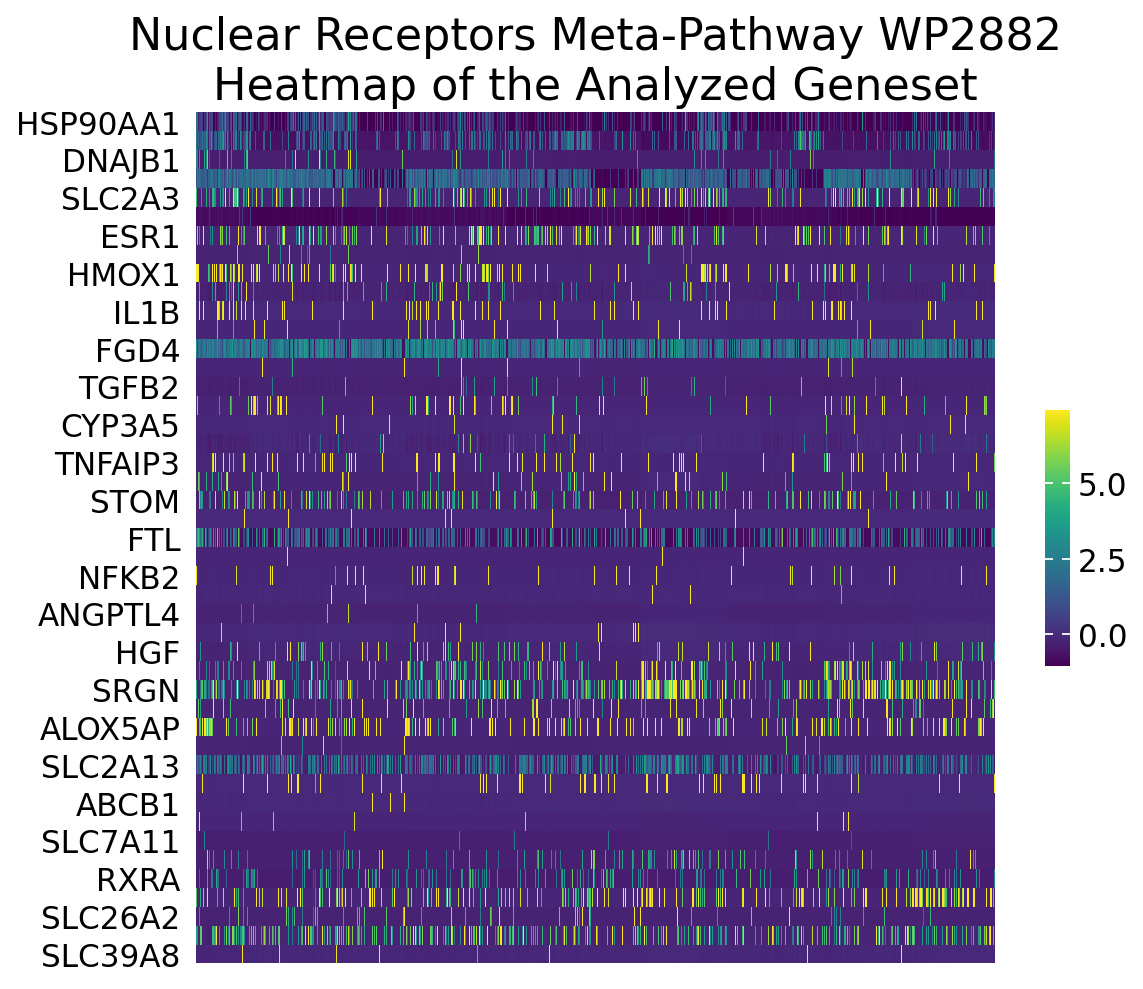

In [33]:
## Heatmap of gene expression
i = 4
genes = res.res2d.Lead_genes.iloc[i].split(";")
gseapy.heatmap(df = res.heatmat.loc[genes],
           z_score=None,
           title=res.res2d.Term.iloc[i],
           figsize=(8,7),
           cmap=plt.cm.viridis,
           xticklabels=False)

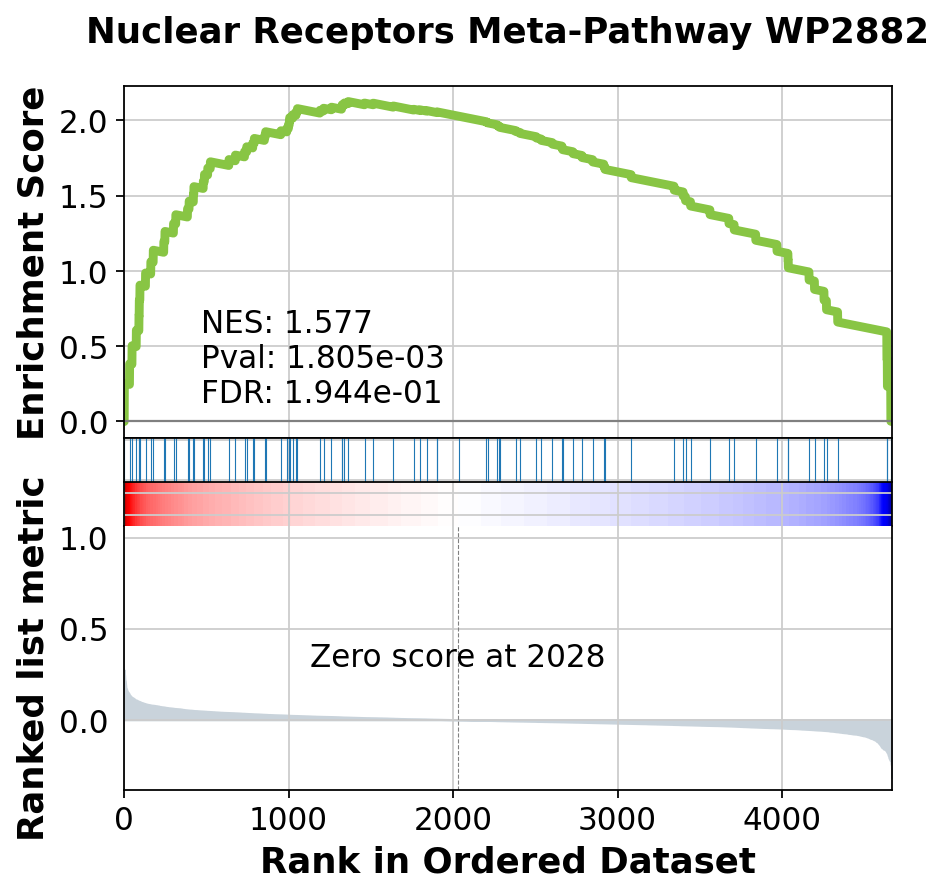

In [34]:
term = res.res2d.Term.iloc[i]
gseapy.gseaplot(res.ranking, term=term, **res.results[term])

# DEG Analysis Microglia

In [35]:
# find degs
sc.tl.rank_genes_groups(MGdata,
                        groupby='Diagnosis',
                        use_raw=False,
                        layer='lognorm',
                        method='wilcoxon',
                        groups=["AD"],
                        reference='Control')

In [36]:
MGdata.X.max() # already log1p

10.0

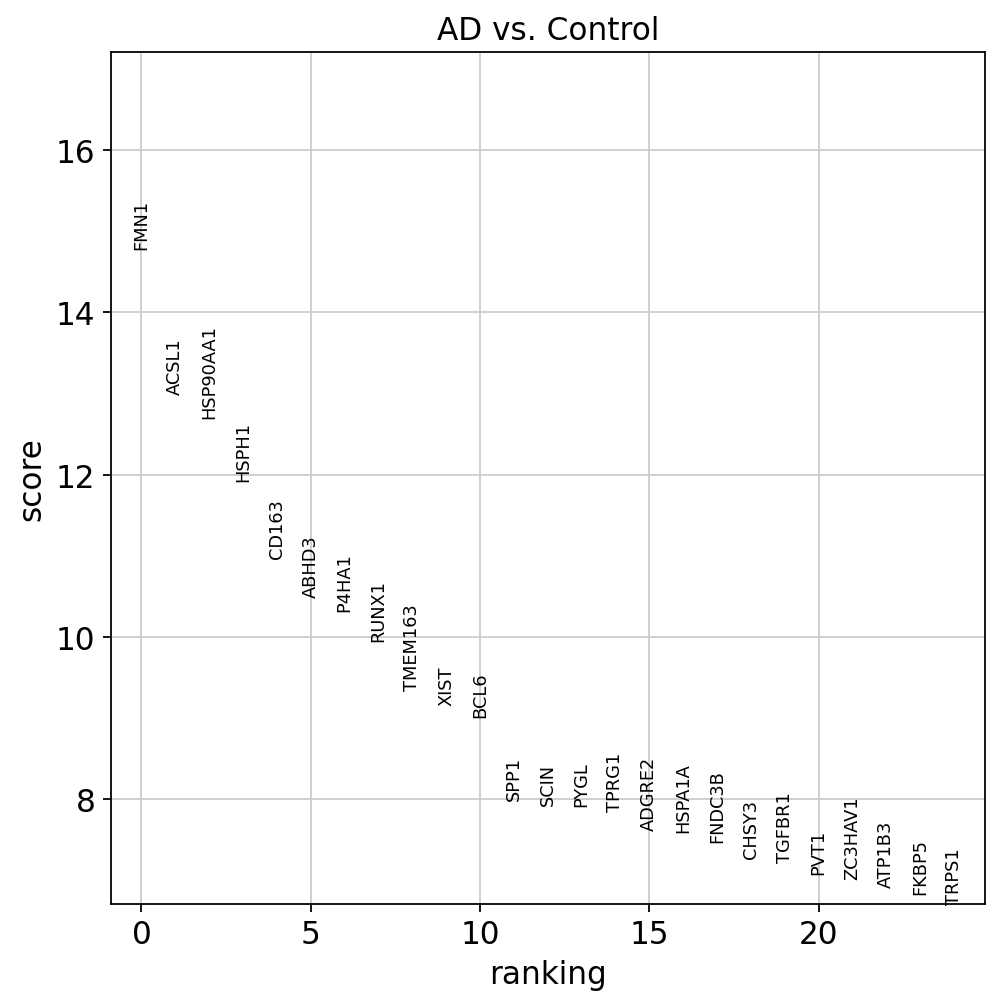

In [37]:
sc.pl.rank_genes_groups(MGdata, n_genes=25, sharey=False)

In [38]:
# get deg result
result = MGdata.uns['rank_genes_groups']
groups = result['names'].dtype.names
degs = pd.DataFrame(
    {group + '_' + key: result[key][group]
    for group in groups for key in ['names','scores', 'pvals','pvals_adj','logfoldchanges']})

In [39]:
degs.head(10)

AD_names  AD_scores      AD_pvals  AD_pvals_adj  AD_logfoldchanges
0      FMN1  14.783522  1.871214e-49  4.367413e-46           4.880651
1     ACSL1  12.987131  1.447517e-38  1.689253e-35           1.742543
2  HSP90AA1  12.693111  6.456870e-37  6.028134e-34           3.320159
3     HSPH1  11.925523  8.713540e-33  4.519423e-30           2.606162
4     CD163  10.971464  5.241681e-28  1.747726e-25           2.493846
5     ABHD3  10.494946  9.112903e-26  2.658690e-23           1.733684
6     P4HA1  10.312671  6.176101e-25  1.695885e-22           1.827639
7     RUNX1   9.942205  2.727215e-23  6.700338e-21           5.344736
8   TMEM163   9.349831  8.778850e-21  1.862712e-18           4.772902
9      XIST   9.154989  5.436339e-20  9.760319e-18           1.534578

# Over-representation analysis (Enrichr API)

In [40]:
# subset up or down regulated genes
degs_sig = degs[degs.AD_pvals_adj < 0.05]
degs_up = degs_sig[degs_sig.AD_logfoldchanges > 0]
degs_dw = degs_sig[degs_sig.AD_logfoldchanges < 0]

In [41]:
degs_up.shape

(194, 5)

In [42]:
degs_dw.shape

(217, 5)

In [43]:
# Enricr API
enr_up = gseapy.enrichr(degs_up.AD_names,
                    gene_sets='GO_Biological_Process_2021',
                    outdir=None)

In [44]:
# trim (go:...)
enr_up.res2d.Term = enr_up.res2d.Term.str.split(" \(GO").str[0]

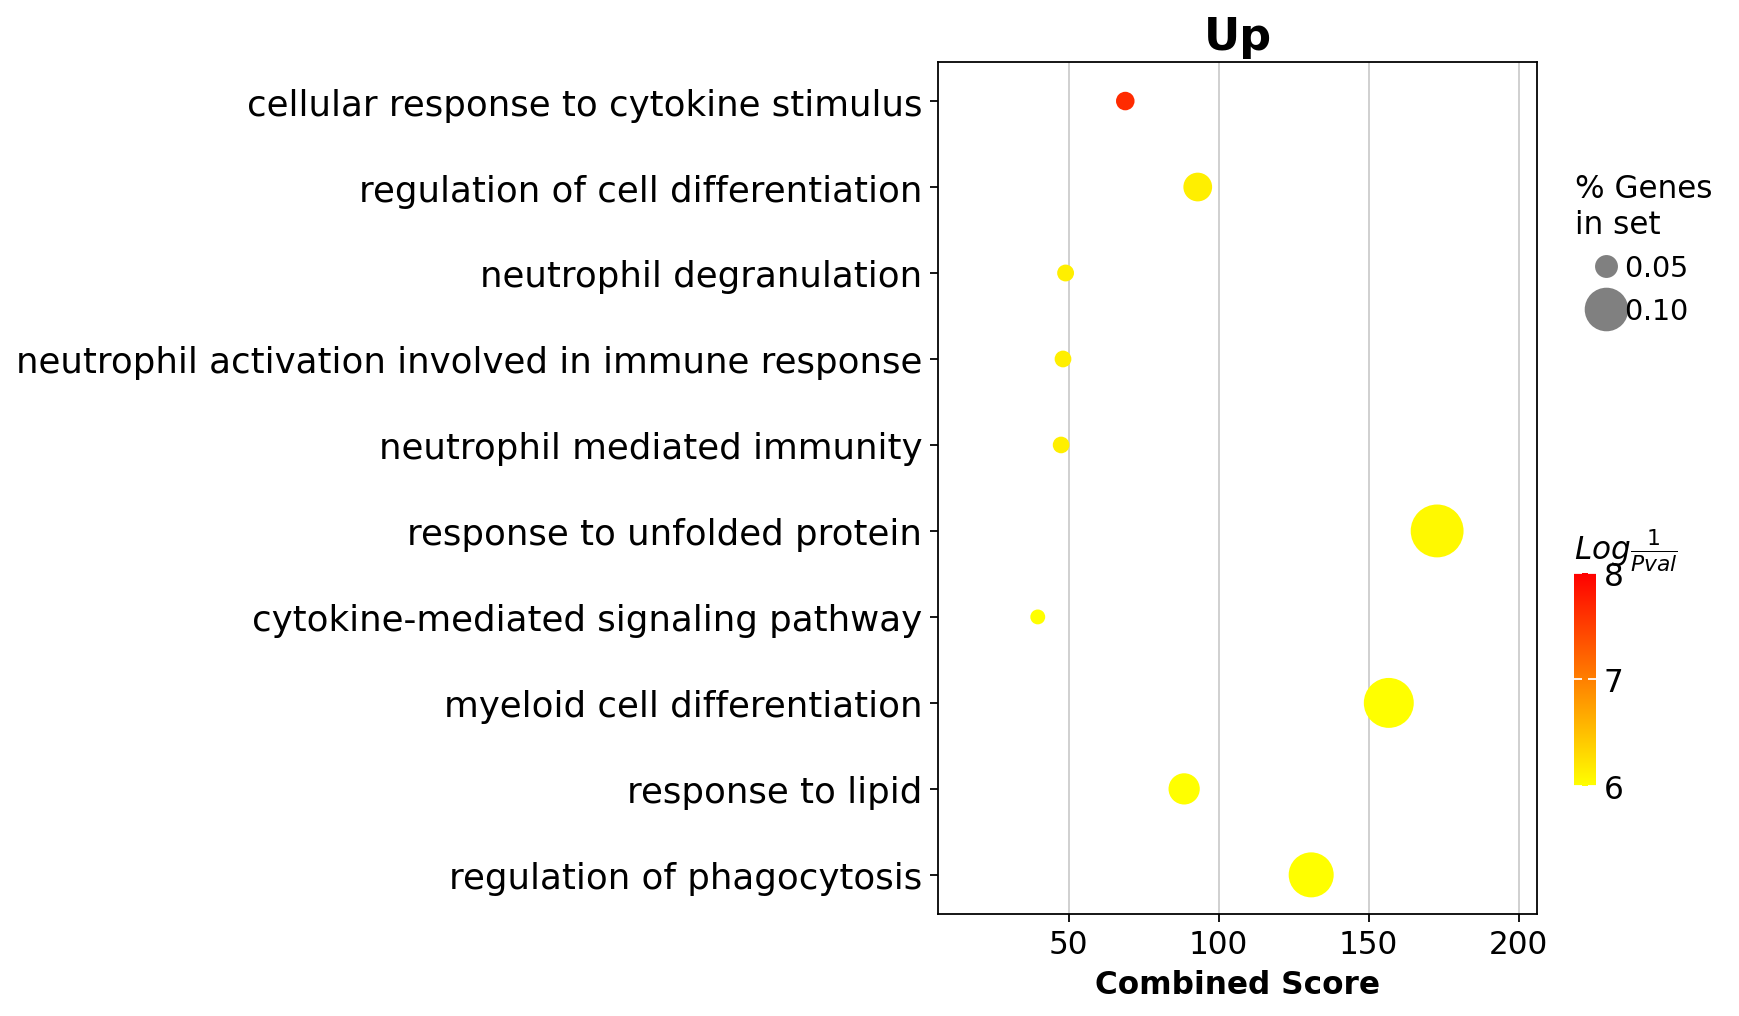

In [45]:
# dotplot
gseapy.plot.dotplot(enr_up.res2d, figsize=(6,7), title="Up", cmap = plt.cm.autumn_r, size = 70)
plt.show()

In [46]:
enr_dw = gseapy.enrichr(degs_dw.AD_names,
                    gene_sets='GO_Biological_Process_2021',
                    outdir=None)

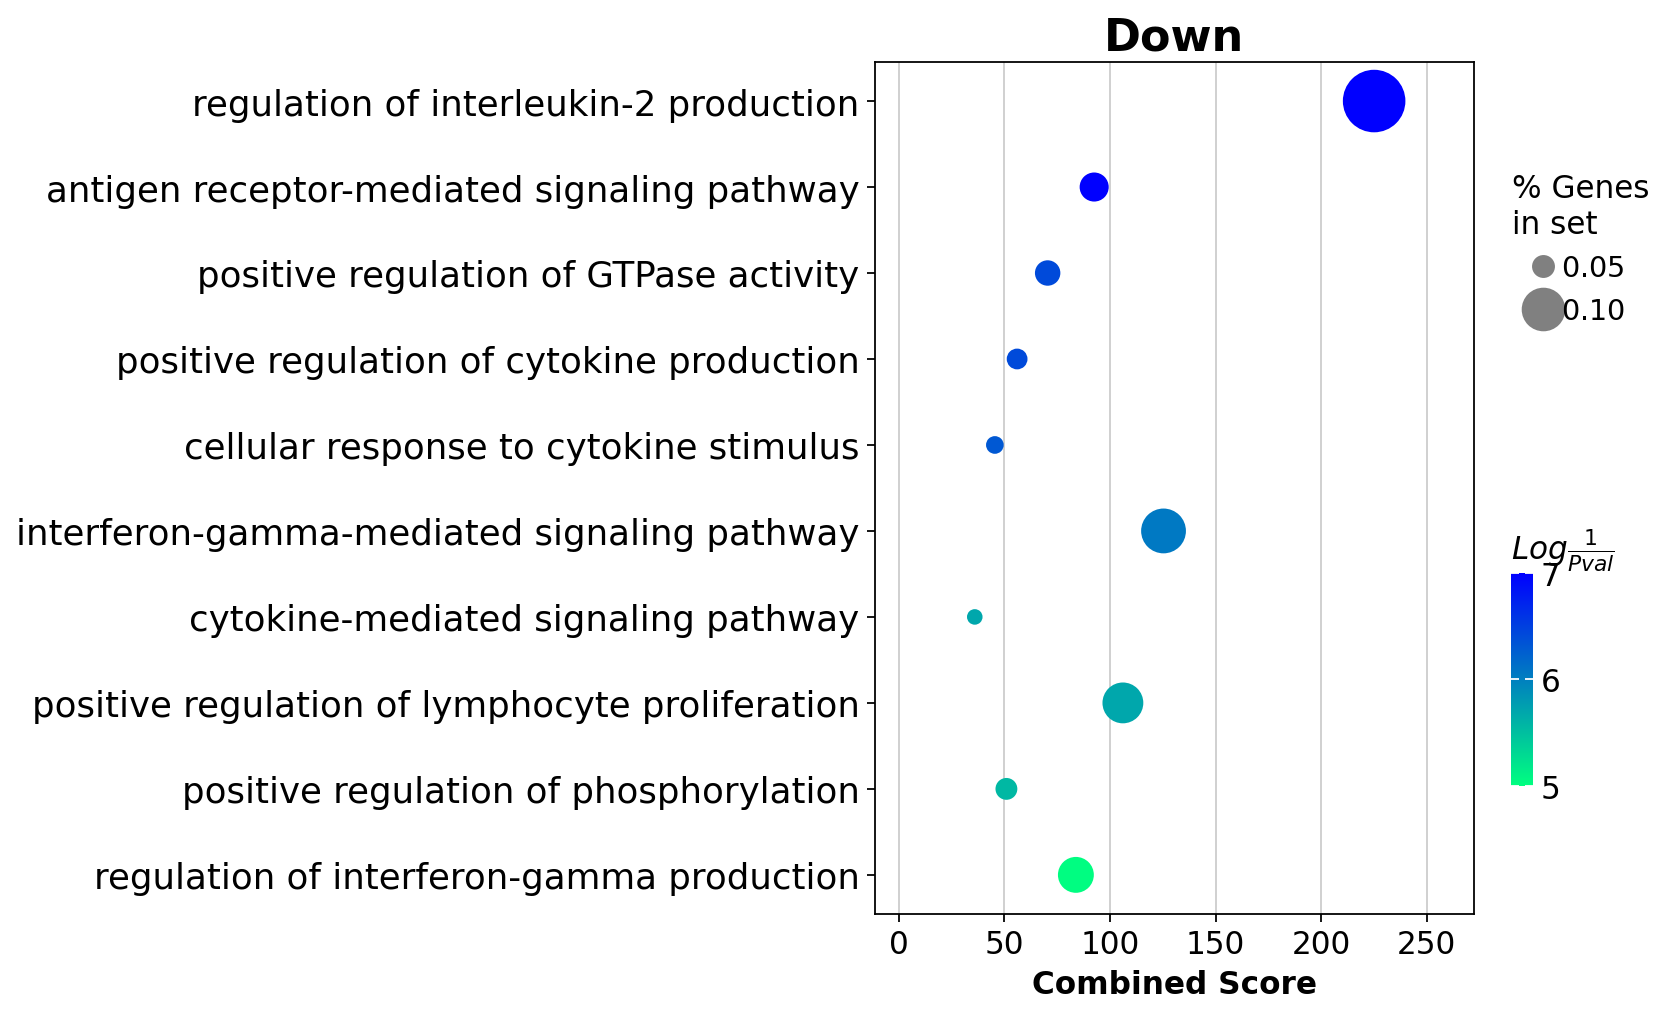

In [47]:
enr_dw.res2d.Term = enr_dw.res2d.Term.str.split(" \(GO").str[0]
gseapy.dotplot(enr_dw.res2d,
           figsize=(6,7),
           title="Down",
           cmap = plt.cm.winter_r,
           size=70)
plt.show()